In [1]:
## modified to handle 2017 CCAR dates (and balance truncation at last hist date for CCAR >= 2016) 
## 20160912: control actual balance history (12/2014 if ccar <= 2015; 12/2015 if ccar = 2016)
## master stress test module: includes state macro variables:
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
## lists of states and banks within regional group to analyze:
## state/region:  if none: stlst=[]; if one only: stlst=['FL']; if multiple states aggregated: stlst=['FL','GA','AL']
#stlst = ['FL','GA']
#stlst = ['NV']
#stlst = ['CA']
stlst=[]

## exclusion list: (enter IDRSSD for each bank to exclude)
exlst = []  ## use this as default
#exlst = [2193616,665931,1212846]  ## FL,GA exclude: Raymond James, Northern Trust, Monogram Credit Card
#exlst = [2502656,3150447,2129008,2036843,3287660,2819167] # NV: USAA, Chas Schwab, Household (SB & NA), Toyota, Farm Bureau
if len(exlst)==0:
  exflg = ''
else:
  exflg = 'x'

#########################################################################
## Pick one of the next 5 lines:  
irflg = '_NoRates'  ## use this to remove rates from regressions
#irflg = '_NoRate_Big3'  ## SPECIAL: designates backtest re-run using only "big 3" vars: UE, HPI, CRE
#irflg = '_NoRate_Big4v'  ## SPECIAL: designates backtest re-run using only "big 4" vars: UE, HPI, CRE, CE
#irflg = ''  ## use this to keep rates in regressions and use all variables in regressions
#irflg = '_Big3' ## use this to keep rates in regressions but limit vars to Big3 only

############################################################
# 12/13/15: new list: brief list of only vars to use in regressions
#   (Note: can be a small number other than 3 if desired... like 4 or 5)
#big3 = ['UE','HPI','CRE']  ### list of big3 variables
#big3 = ['UE','HPI','CRE','VIX']  ### list of big3 vars + VIX
big3=[]  ## use this if Big3 not selected

## WARNING:  Select small group of unique banks here:
rslst=[]  # IDRSSD list for ad hoc 
#rslst = [598534]  ## Fidelity (GA)
tclst=[]  # ticker list for ad hoc
#tclst = ['CCBG']  ## Capital City (FL)

##########################################################################
##  NOTE:  Large bank exclusions:  Pick one of 3 options:
##  'x00':  Include all banks (do not exclude any)
##  'x18':  Exclude CCAR 18-bank group and their acquired/merged banks
##  'x31':  Exclude CCAR 31-bank group and their acquired/merged banks
xtyp = 'x00'  ## pick 'x00', 'x18', or 'x31' only, (with grpC18, use x00 only)

htyp = ''  # use this for ultcert tickers (to catch acquired/consolidated banks in history)
#htyp = 'nohist' # use this for current affiliates only

## group name: select one line only among choices:
## (note: only one group can be specified, but all groups will be available for further analysis later!)
## (this label will be used to name all output files to make it easy to locate them later)
grp = 'grp' + 'TotUS' + xtyp + exflg + htyp # use this for TotUS target group
#grp = 'grp' + 'C18' + xtyp + exflg + htyp # use this for C18 target group
#grp = 'grp' + 'C31' + xtyp + exflg + htyp # use this for C31 target group
#grp = 'grp' + ''.join(stlst) + xtyp + exflg + htyp # use this for statelist (1, 2, or 3 states only)
#grp = 'grp' + 'CapFid' # use this for any other grouping (fill in a unique name into 'CapFid' spaces)

USflg = 'Yes'  # 'Yes' means run TotUSx00,x18,x31 groups, 'No' means do not run all 3 TotUS groups
Cxflg = 'Yes'  # 'Yes' means run C18x00 and C31x00 groups, 'No' means do not run both of those groups
indiv = 'No'  # 'Yes' means run indiv banks/tickers, 'No' means do not run indiv banks/tickers

## flags for var transforms to use: orig, lag, exp
vtyp = 2  # 0: Original vars+CE, no transformations; 1: lags (UE,HPI,CRE,CE 4q lags); 2: Lags & sUE2
qtyp = 4  # 4: rolling 4q NCO rates, 1: 1qtr NCO rates (annualized)

if qtyp == 1:
  rtyp = "1q"
  rskp = 0
  curlst = ['qcTotLn','qcCx','qcSfRev','qcSfTD','qcMult','qcCRE','qcCIdom','qcCard','qcOthCsmr','qcCREtot']
elif qtyp == 4:
  rtyp = "4q"
  rskp = 3
  curlst = ['rcTotLn','rcCx','rcSfRev','rcSfTD','rcMult','rcCRE','rcCIdom','rcCard','rcOthCsmr','rcCREtot']
else:
  rskp = 999
  rclst = []  # force error

cbo = ['Orig', 'Lags', 'Lags_sUE2']  # descriptors for vtyp code
styp = cbo[vtyp]  # selects one of the cbo codes based on vtyp entry.

grporig = grp
grp, styp, irflg

('grpTotUSx00', 'Lags_sUE2', '_NoRates')

In [3]:
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])

hs['DJ'] = hs['DJ']/1000
cc['DJ'] = cc['DJ']/1000

cc2 = cc.dropna(how='any',axis=1)  # remove any vars that are missing in any ccar year (removes T5y, Prime)
cccol = list(cc2.columns)[3:]
hs2 = hs[['Date']+cccol]
hs2.set_index('Date', drop=True, inplace=True)
hs2 = hs2.ix['2000-01':]
hscol = list(hs2.columns)  # original ccar variables

In [4]:
## Tickers to exclude from aggregates: CCAR 18-bank and 31-bank groups:
c18tic = ['ALLY','AXP','BAC','BBT','BK','C','COF','FITB','GS','JPM','KEY','MS','PNC','RF','STI','STT','USB','WFC']
c31tic = c18tic + ['BMO','BBVA','CFG','CMA','DB','DFS','HSBC','HBAN','MTB','MTU','NTRS','SAN','ZION']

In [5]:
#########################################################
## section to download CE and state CE & UE variables
#########################################################

In [6]:
## prepare to gather nominal GDP from FRED database:
import pandas.io.data as web
start = pd.datetime(2000,1,1)
end = pd.datetime(2016,12,31)  # NOTE:  adjust this if processing 2016 or later quarters

In [7]:
if len(stlst) == 0:
  print("No states selected.")
else:
  print("OK to proceed.")

No states selected.


In [8]:
## process only if len(stlst)>0:
uestq = []
if len(stlst) > 0:
  uelst = [s + 'UR' for s in stlst]  ## codes for unemployment rate in FRED database: 'FLUR' = FL unemp rate 
  lflst = [s + 'LF' for s in stlst]  ## codes in FRED database: 'FLLF' = FL labor force
  ## NOTE:  use labor force values as weightings for regional aggregates of state UE rates
  uest = web.DataReader(uelst+lflst,'fred',start,end)  ## download data in uest dataframe
  uest['UE_'+''.join(stlst)] = uest.apply(lambda x:np.average(x[[z+'UR' for z in stlst]],\
                                           weights=x[[z+'LF' for z in stlst]]),axis=1)
  uestq = uest.resample('Q').mean()

if len(uestq)>0:
  print(uestq.head(2))
else:
  print('No state UE')

No state UE


In [9]:
celst = [] # CE codes for FRED database
telst = [] # TotEmployment codes for FRED database

if len(stlst)>0: celst = [s + 'CONS' for s in stlst]  ## codes for unemployment rate in FRED database: 'FLCE' = FL constr emp
celst = ['USCONS'] + celst
if len(stlst)>0: telst = [s + 'NA' for s in stlst]  ## FLNA is Florida total non-farm employment
telst = ['PAYEMS'] + telst
cest = web.DataReader(celst+telst,'fred',start,end)  ## download data in uest dataframe
if len(stlst)>0:
  cest[''.join(stlst)+'CONS'] = cest.apply(lambda x:np.sum(x[[z+'CONS' for z in stlst]]),axis=1)
  cest[''.join(stlst)+'NA'] = cest.apply(lambda x:np.sum(x[[z+'NA' for z in stlst]]),axis=1)
cest[['USCONS','PAYEMS']] = cest[['USCONS','PAYEMS']].astype('float')
cestq = cest.resample('Q').mean()
cestq.ix['2014']

USCONS         PAYEMS
DATE                                  
2014-03-31  6015.333333  137755.333333
2014-06-30  6110.000000  138581.333333
2014-09-30  6203.000000  139314.666667
2014-12-31  6270.666667  140098.000000

In [10]:
cestq['CE'] = cestq['USCONS']*100 / cestq['PAYEMS']
if len(stlst)>0: cestq['CE_'+''.join(stlst)] = cestq[''.join(stlst)+'CONS']*100 / cestq[''.join(stlst)+'NA']
cestq.tail()

USCONS         PAYEMS        CE
DATE                                            
2015-12-31  6583.666667  142835.000000  4.609281
2016-03-31  6668.666667  143444.000000  4.648969
2016-06-30  6694.666667  143953.666667  4.650570
2016-09-30  6713.000000  144657.333333  4.640622
2016-12-31  6765.666667  145167.000000  4.660609

In [11]:
if 'CE' not in list(hs2.columns): 
  hs2 = hs2.merge(cestq[['CE']],how='outer',left_index=True, right_index=True)
  if len(stlst)>0: 
    hs2 = hs2.merge(cestq[['CE_'+''.join(stlst)]],how='left',left_index=True, right_index=True)
    hs2 = hs2.merge(uestq[['UE_'+''.join(stlst)]],how='left',left_index=True, right_index=True)
hs2.tail()

rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T10y  BBB  Mort      DJ  \
Date                                                                           
2015-12-31    0.9    1.8   3.0   3.4  5.0  0.8  0.1   2.2  4.6   3.9  21.101   
2016-03-31    0.8    1.3   2.1   2.4  4.9 -0.3  0.3   2.0  4.6   3.7  21.179   
2016-06-30    1.4    3.7   2.9   5.0  4.9  2.5  0.3   1.8  4.1   3.6  21.621   
2016-09-30    3.5    5.0   2.6   4.1  4.9  1.6  0.3   1.6  3.7   3.4  22.469   
2016-12-31    3.1    6.1   1.6   4.5  4.7  3.4  0.4   2.2  4.1   3.9  23.277   

              HPI    CRE   VIX        CE  
Date                                      
2015-12-31  174.0  277.0  24.4  4.609281  
2016-03-31  177.0  278.0  28.1  4.648969  
2016-06-30  179.0  283.0  25.8  4.650570  
2016-09-30  182.0  290.0  18.1  4.640622  
2016-12-31  183.0  294.0  22.5  4.660609

In [12]:
### remove all interest rate variables: (They interfere with scenario forecasts.)
xvr = ['Mort','T3m','T5y','T10y','Prime','BBB'] ## xvr: interest rate CCAR vars to exclude from regressions

### ALWAYS remove int rates for this set of regressions for CE ,CE_st and UE_st variables!!!!
cccol = [x for x in cccol if x not in xvr]  ## removes interest rate vars from cccol (ccar var columns)
cccol

['rGDPg', 'nGDPg', 'rDIg', 'nDIg', 'UE', 'CPI', 'DJ', 'HPI', 'CRE', 'VIX']

In [13]:
## 3-var models:
## hs2, cc2 have removed T5y and Prime since those are not in CCAR 2012 or 2013 variables
hsy = hs2.copy()
hsz = hs2.copy()
hsz['Intercept'] = 1.0
hsz.reset_index(drop=False,inplace=True)
ccs = cc2.copy()
ccs.sort_index(by=['Scen','Date'],inplace=True)
ccs['Intercept'] = 1.0
svlst = [x for x in list(hs2.columns) if x not in hscol]
curlst = svlst
topn = 1  # number of final models to review (use topn=1 for production)
topx = 2  # number of 2-var pairs to allow in final 3 for 3-var models
curlst

['CE']

In [14]:
### build 3-var models:

In [15]:
def df1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

df1 = pd.DataFrame(columns=['rc','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for rc in curlst:
  for v in cccol:
    y, X = dmatrices( rc + ' ~ ' + v , data=hsy, return_type='dataframe')
    mod = sm.OLS(y, X)
    res = mod.fit()
    df1 = df1.append({'rc': rc,'v1': v, 'r1': res.rsquared_adj}, ignore_index=True)

df1g = df1.groupby(['rc'])
df1t = df1g.apply(df1_topx)
df1t.index = np.arange(len(df1t))

# stores r-sq values for all 2-var combos:
df2 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'rc','x', 'y'}))  # to retain processed var-pairs

for idx, row in df1t.iterrows():
  for v in cccol:
    if (row['v1'] == v) | ({row['rc'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df2 = df2.append({'rc':row['rc'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.rsquared_adj}, ignore_index=True)
      st2.add(frozenset({row['rc'], v, row['v1']}))

In [16]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = df2.groupby(['rc','v1'])
df2a = grouped.apply(get_topx_2var)
df2a = df2a.sort_index(by=['rc','r2','r1'], ascending=[True,False,False])
df2a.index = np.arange(len(df2a))

# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
df3 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cf3 = pd.DataFrame(columns=['Int','c1','c2','c3'])
st3 = set(frozenset({'rc','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df2a.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['rc'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df3 = df3.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],'v3':v,\
                        'r3': res.rsquared_adj},ignore_index=True)
      st3.add(frozenset({row['rc'],v, row['v1'], row['v2']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3']
      cf3 = cf3.append(cm.ix[0])

cf3 = cf3.reset_index(drop=True)
df3 = df3.reset_index(drop=True)
df3 = df3.merge(cf3, how='inner', left_index=True, right_index=True)

In [17]:
# function to select topn models for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

df3g = df3.groupby(['rc','v1','v2'])  #  allows topx for each primary 2-var pair
df3a = df3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
df3ag = df3a.groupby(['rc'])  # prep to find topn best models for each product category
df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
df3b.index = np.arange(len(df3b))


In [18]:
df3b.to_csv(grp+"_3var_stvar_params.csv")

In [19]:
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
df4 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cf4 = pd.DataFrame(columns=['Int','c1','c2','c3','c4'])
st4 = set(frozenset({'rc','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df3b.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['rc'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['rc']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df4 = df4.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                        'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.rsquared_adj},ignore_index=True)
      st4.add(frozenset({row['rc'],v, row['v1'], row['v2'], row['v3']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3','c4']
      cf4 = cf4.append(cm.ix[0])

cf4 = cf4.reset_index(drop=True)
df4 = df4.reset_index(drop=True)
df4 = df4.merge(cf4, how='inner', left_index=True, right_index=True)

In [20]:
# function to select top 3 for each lead variable:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topx]

def get_topn_4rc(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topn]

df4g = df4.groupby(['rc','v1','v2','v3'])  #  allows topx for each primary 3-var pair
df4a = df4g.apply(get_topx_4var)  ## finds best topx models from each 4-var combo
df4ag = df4a.groupby(['rc'])  # prep to find topn best models for each product category
df4b = df4ag.apply(get_topn_4rc)  # find topn models among all 4-var models
df4b.index = np.arange(len(df4b))


In [21]:
df4b.to_csv(grp+"_4var_stvar_params.csv")
df4b

rc  v1        r1  v2        r2   v3        r3   v4        r4       Int  \
0  CE  UE  0.563293  DJ  0.841586  HPI  0.958898  CPI  0.959981  6.186079   

         c1        c2        c3        c4  
0 -0.213327 -0.085896  0.007928  0.008935

In [22]:
### sections to generate forecasts for all 4-var models:

for idx, row in df4b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs[rc] = p_tot


In [23]:
ccp = ccs[ccs.Scen.isin(['Bas','Sev'])].copy()
ccp['yrscen'] = ccp.apply(lambda x: str(x['CCAR'])[-2:]+'_'+x['Scen'],axis=1)
ccp.sort_index(by=['CCAR','Scen','Date'],inplace=True)
ccp.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T10y  BBB  \
236  2017  Sev 2019-12-31    3.9    4.9   2.6   3.8  9.1  1.6  0.1   1.7  3.8   
237  2017  Sev 2020-03-31    3.9    4.8   2.5   3.6  8.9  1.4  0.1   1.8  3.6   

     Mort      DJ    HPI    CRE   VIX  Intercept        CE  yrscen  
236   3.9  21.186  142.0  203.0  14.9        1.0  3.565089  17_Sev  
237   3.8  22.577  145.0  207.0  14.3        1.0  3.510270  17_Sev

In [24]:
svlst

['CE']

In [25]:
cc[cc['CCAR']==2015].tail()

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  \
149  2015  Sev 2016-12-31    3.0    4.3   1.8   3.3  9.9  1.9  0.1  0.9   1.9   
150  2015  Sev 2017-03-31    3.9    5.2   2.7   4.2  9.7  1.9  0.1  1.1   2.0   
151  2015  Sev 2017-06-30    3.9    5.2   2.8   4.1  9.5  1.7  0.1  1.2   2.1   
152  2015  Sev 2017-09-30    3.9    5.1   2.9   4.2  9.3  1.6  0.1  1.3   2.2   
153  2015  Sev 2017-12-31    3.9    5.1   3.0   4.3  9.1  1.6  0.1  1.5   2.3   

     BBB  Mort  Prime       DJ    HPI    CRE   VIX  
149  5.5   4.7    3.2  11.5214  128.4  154.6  21.6  
150  5.3   4.7    3.2  12.8947  127.9  156.1  18.7  
151  5.2   4.7    3.2  14.0792  128.4  159.6  17.6  
152  5.1   4.7    3.2  15.4303  129.5  164.0  16.4  
153  5.1   4.7    3.2  16.4876  131.0  169.1  16.5

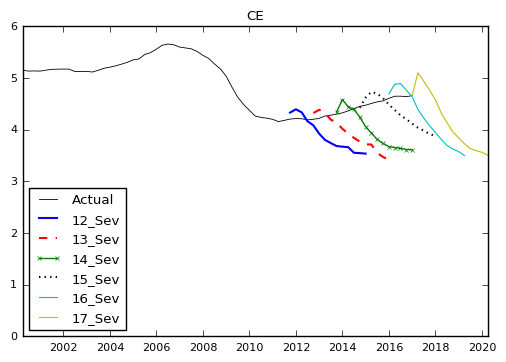

In [26]:
i = 0  ## enter 0, 1, or 2 only (for 3 items in svlst)
gr = pd.DataFrame(hsy[svlst[i]])
gr.rename(columns={svlst[i]:'Actual'},inplace=True)
cp3 = ccp[['yrscen','Date',svlst[i]]]
cp3 = cp3.pivot('Date','yrscen',svlst[i])

gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)
xa = list(gr3.index)

plt.rcParams.update({'font.size': 8})
plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
#plt.plot(xa, gr3['12_Bas'],c='b',ls=':',lw=1.3,label="12_Bas")
plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
#plt.plot(xa, gr3['13_Bas'],c='r',ls=':',lw=1.3,label="13_Bas")
plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
#plt.plot(xa, gr3['14_Bas'],c='g',ls=':',lw=1.3,label="14_Bas")
plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
#plt.plot(xa, gr3['15_Bas'],c='k',ls=':',lw=1.3,label="15_Bas")
plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
plt.plot(xa, gr3['17_Sev'],c='y',ls='-',lw=.8,label="17_Sev")
plt.title(svlst[i])
plt.ylim(ymin=0)
if svlst[i][0:2] == 'CE':
  lc = 3
else:
  lc = 2
plt.legend(loc=lc) # 2 (UE) or 3 (CE)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [27]:
svlst2 = svlst + ['UE']
svlst2.sort()
svlst2

['CE', 'UE']

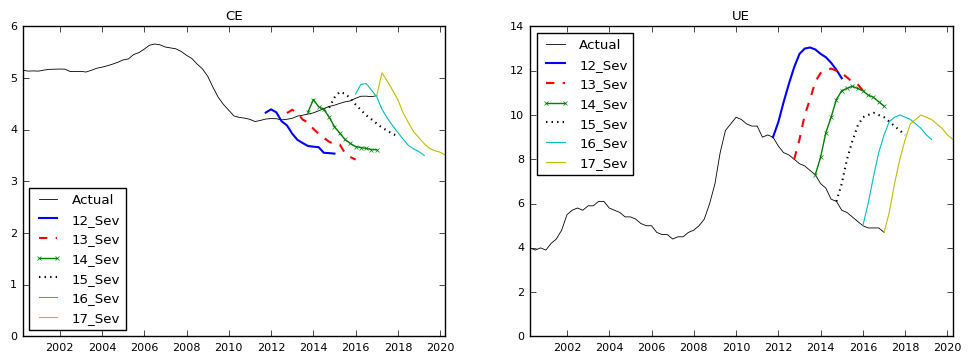

In [28]:
xa = list(gr3.index)

## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )

j=0  ## 0 or 2 only
for i in np.arange(2):
  plt.subplot(1, 2, i+1)
  gr = pd.DataFrame(hsy[svlst2[i+j]])
  gr.rename(columns={svlst2[i+j]:'Actual'},inplace=True)
  cp3 = ccp[['yrscen','Date',svlst2[i+j]]]
  cp3 = cp3.pivot('Date','yrscen',svlst2[i+j])

  gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)

  plt.rcParams.update({'font.size': 8})
  plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
  plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
  plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
  plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
  plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
  plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
  plt.plot(xa, gr3['17_Sev'],c='y',ls='-',lw=.8,label="17_Sev")
  plt.title(svlst2[i+j])
  plt.legend(loc=0)
  plt.ylim(ymin=0)

plt.savefig("Var"+svlst2[i+j]+'_4var.png', dpi=400, bbox_inches='tight')
plt.show()

In [29]:
"Var"+svlst2[i+j]+'_4var.png',

('VarUE_4var.png',)

In [30]:
xa = list(gr3.index)

## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )

j=2  ## 0 or 2 only
if len(svlst2)==4:
  for i in np.arange(2):
    plt.subplot(1, 2, i+1)
    gr = pd.DataFrame(hsy[svlst2[i+j]])
    gr.rename(columns={svlst2[i+j]:'Actual'},inplace=True)
    cp3 = ccp[['yrscen','Date',svlst2[i+j]]]
    cp3 = cp3.pivot('Date','yrscen',svlst2[i+j])

    gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)

    plt.rcParams.update({'font.size': 8})
    plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
    plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
    plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
    plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
    plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
    plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
    plt.plot(xa, gr3['17_Sev'],c='y',ls='-',lw=.8,label="17_Sev")
    plt.title(svlst2[i+j])
    plt.legend(loc=0)
    plt.ylim(ymin=0)

if len(svlst2)== 4:
  plt.savefig("Var"+svlst2[i+j]+'_4var.png', dpi=400, bbox_inches='tight')
  plt.show()
else:
  print('No output...')

No output...


In [31]:
stcol = [x for x in list(hs2.columns) if x not in list(hs.columns)]  ## list of new variables to process
stcol

['CE']

In [32]:
## add new state and CE columns to original history variable table ('hs'), call it hs3
if len(stcol)>0:
  hs3 = hs.copy()
  hs3.set_index('Date',drop=True,inplace=True)
  hs3 = hs3.ix['2000':]
  hs3 = hs3.merge(hs2[stcol],how='left',left_index=True,right_index=True)

hs3.head(2)

rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  Mort  \
Date                                                                        
2000-03-31    1.2    4.3   8.1  11.8  4.0  4.0  5.5  6.6   6.7  8.2   8.3   
2000-06-30    7.8   10.2   4.2   6.1  3.9  3.2  5.7  6.5   6.4  8.5   8.3   

            Prime      DJ    HPI    CRE   VIX        CE  
Date                                                     
2000-03-31    8.7  14.296  102.0  125.0  27.0  5.153686  
2000-06-30    9.2  13.619  105.0  124.0  33.5  5.135663

In [33]:
## add new state and CE columns to original ccar variable table ('cc'), call it cc3:
if len(stcol)>0:
  cc3 = cc.copy()
  cc3.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  cc3 = cc3.merge(ccs[['CCAR','Scen','Date']+stcol],how='left',on=['CCAR','Scen','Date'])

cc3.head(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.0  2.6  0.0  NaN   2.5   
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.1  1.9  0.1  NaN   2.2   

    BBB  Mort  Prime        DJ     HPI     CRE    VIX        CE  
0  4.90  4.20    NaN  11.67700  132.00  177.00  48.00  4.332863  
1  4.52  4.21    NaN  11.93609  137.21  172.17  35.97  4.324326

In [34]:
hs3.to_csv(grp+'_histvars.csv')
cc3.to_csv(grp+'_ccarvars.csv')

In [35]:
## end of state variable (and CE) processing... move onto gathering bank data

In [36]:
## gather Call Rpt data for requested groups:

In [38]:
## process Call Rpt data for requested banks:
## rk table will be used to find identifiers (and associated acquired banks for BHCs)
if htyp == 'nohist':
  rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_nohist201612.csv", index_col=0)  # 20160508 nohist version
else:
  rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_ult201612.csv", index_col=0)  # fixed 3 dup tickers (FBMS,FCBC,RBCAA)

rk['xAsOf'] = pd.to_datetime(rk['xAsOf'])
rk['nAsOf'] = pd.to_datetime(rk['nAsOf'])
rk['FailDate'] = pd.to_datetime(rk['FailDate'])
htyp

''

In [39]:
rk['C18'] = 'No'
rk['C31'] = 'No'
#c18tic
rk.loc[rk.Ticker.isin(c18tic), 'C18']='C18'
rk.loc[rk.Ticker.isin(c31tic), 'C31']='C31'

In [40]:
b18 = set(list(rk[rk['C18']=='C18']['IDRSSD']))  ## C18 banks 
b31 = set(list(rk[rk['C31']=='C31']['IDRSSD']))  ## C31 banks 

len(b18), len(b31), len(exlst)

(447, 609, 0)

In [41]:
############ CAUTION
############ CAUTION

In [42]:
## CAUTION:  DO NOT RE-RUN THIS CELL if it was run earlier in session (wastes a lot of time)
## read Call Report extract file for all banks:
dg2 = pd.read_csv("df2_2001_201612.csv")
dg2['AsOf'] = pd.to_datetime(dg2['AsOf'])

fcol = dg2.columns[5:]  ## get listing of numeric fields, then...
dg2[fcol] = dg2[fcol].astype(float)  ### CRITICAL to convert numeric data to FLOAT!!! (since some are ints)

In [43]:
dcol = list(dg2)[5:]  ## data column names
dcol[0:5]

['Cert', 'eTotAst', 'eTotLn', 'eALLL', 'eOREO']

In [44]:
## grpTotUSx00:
px00 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px00 = dg2[['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px00n = dg2[['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px00n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px00 = px00.merge(px00n,how='left',left_index='True',right_index='True')
  px00 = px00.reset_index(drop=False)
  px00['IDRSSD'] = 0
  px00['Grp'] = 'grp' + 'TotUS' + 'x00' + htyp
  px00 = px00[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px00)

64

In [45]:
## grpTotUSx18:
px18 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px18 = dg2[~dg2['IDRSSD'].isin(b18)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px18n = dg2[~dg2['IDRSSD'].isin(b18)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px18n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px18 = px18.merge(px18n,how='left',left_index='True',right_index='True')
  px18 = px18.reset_index(drop=False)
  px18['IDRSSD'] = 0
  px18['Grp'] = 'grp' + 'TotUS' + 'x18' + htyp
  px18 = px18[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px18)

64

In [46]:
## grpTotUSx31:
px31 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px31 = dg2[~dg2['IDRSSD'].isin(b31)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px31n = dg2[~dg2['IDRSSD'].isin(b31)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px31n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px31 = px31.merge(px31n,how='left',left_index='True',right_index='True')
  px31 = px31.reset_index(drop=False)
  px31['IDRSSD'] = 0
  px31['Grp'] = 'grp' + 'TotUS' + 'x31' + htyp
  px31 = px31[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px31)

64

In [47]:
#C18 processing:
pcx18=[]
if ('C18' in grp)|(Cxflg=='Yes'):
  clst=[]
  xlst = []

  pcx18 = dg2[dg2['IDRSSD'].isin(b18)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pcx18n = dg2[dg2['IDRSSD'].isin(b18)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pcx18n.rename(columns={'eTotAst':'nbr'},inplace=True)
  pcx18 = pcx18.merge(px18n,how='left',left_index='True',right_index='True')
  pcx18 = pcx18.reset_index(drop=False)
  pcx18['IDRSSD'] = 0
  pcx18['Grp'] = 'grpC18x00'
  pcx18 = pcx18[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pcx18)

64

In [48]:
# C31 processing:
pcx31=[]
if ('C31' in grp)|(Cxflg=='Yes'):
  clst=[]
  xlst = []

  pcx31 = dg2[dg2['IDRSSD'].isin(b31)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pcx31n = dg2[dg2['IDRSSD'].isin(b31)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pcx31n.rename(columns={'eTotAst':'nbr'},inplace=True)
  pcx31 = pcx31.merge(px31n,how='left',left_index='True',right_index='True')
  pcx31 = pcx31.reset_index(drop=False)
  pcx31['IDRSSD'] = 0
  pcx31['Grp'] = 'grpC31x00'
  pcx31 = pcx31[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pcx31)

64

In [49]:
## state level aggregates: # 20160414:  run x00
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
pxstx00 = []
if len(stlst)>0:
  xt = 'x00'
  stx = []
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  if len(stx)==0: strs = [x for x in strs]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pxst.merge(pxstn,how='left',left_index='True',right_index='True')
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx00 = pxst.copy()

len(pxstx00)

0

In [50]:
stlst

[]

In [51]:
## state level aggregates: # 20160414:  run x18x
pxstx18x=[]
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
if (len(stlst)>0)&(exflg=='x'):
  xt = 'x18'
  stx = list(b18) + exlst
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pxst.merge(pxstn,how='left',left_index='True',right_index='True')
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt + exflg + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx18x = pxst.copy()

len(pxstx18x)

0

In [52]:
## state level aggregates: # 20160414:  run x18
pxstx18=[]
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
if (len(stlst)>0):
  xt = 'x18'
  stx = list(b18) 
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pxst.merge(pxstn,how='left',left_index='True',right_index='True')
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt  + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx18 = pxst.copy()

len(pxstx18)

0

In [53]:
prd='eTotLn'
dgp5=[]

if len(stlst)>0:
  dgp = dg2[(dg2[prd]>0)&(dg2.State.isin(stlst))][['IDRSSD','Name','AsOf',prd]]
  dgp.sort_index(by=['IDRSSD',prd],ascending=[True,False],inplace=True)

  dgp.sort_index(by=['IDRSSD','AsOf'],inplace=True)
  dgp5 = dgp.ix[dgp.groupby(['IDRSSD']).apply(lambda x: x[prd].idxmax())]
  dgp5 = dgp5.merge(rk[['IDRSSD','Ticker','C18','C31','xState','xCert','xAsOf']],how='left',on='IDRSSD')
  dgp5.sort_index(by=[prd],ascending=False,inplace=True)
  dgp5.to_csv(grp+"_"+prd+"_maxbal.csv")

if len(dgp5)>20: dpg5=dgp5[0:20]
    
dgp5

[]

In [54]:
# process requested tickers and IDRSSDs:
pxbk = []
if (len(tclst)>0)&(indiv=='Yes'):
  bkrs=rslst+list(rk[rk['Ticker'].isin(tclst)]['IDRSSD'])
  bknm=list(rk[rk['IDRSSD'].isin(bkrs)]['xName'])
  pxbk = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxbkn = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxbkn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxbk = pxbk.merge(pxbkn,how='left',left_index='True',right_index='True')
  pxbk = pxbk.reset_index(drop=False)
  pxbk['IDRSSD'] = 0
  pxbk['Grp'] = grp
  pxbk = pxbk[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pxbk), grp

(0, 'grpTotUSx00')

In [55]:
# rslst processing:
pxri = []
if (len(rslst)>0)&(indiv=='Yes'):
  for i in np.arange(len(rslst)):
    bknm=rk[rk['IDRSSD']==rslst[i]]['xName']
    pxrj = dg2[dg2['IDRSSD']==rslst[i]][['AsOf']+dcol].groupby(by=['AsOf']).sum()
    pxrjn = dg2[dg2['IDRSSD']==rslst[i]][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
    pxrjn.rename(columns={'eTotAst':'nbr'},inplace=True)
    pxrj = pxrj.merge(pxrjn,how='left',left_index='True',right_index='True')
    pxrj = pxrj.reset_index(drop=False)
    pxrj['Grp'] = 'grp' + ''.join([x[0:3] for x in list(bknm)[0].split()]) + str(i)
    pxrj['IDRSSD'] = rslst[i]
    pxrj = pxrj[['AsOf','Grp','IDRSSD','nbr']+dcol]
    if i==0:
      pxri = pxrj.copy()
    else:
      pxri = pd.concat([pxri,pxrj],ignore_index=True)

len(pxri)

0

In [56]:
# tclst processing:  ## 20160505: handles multiple tickers in tclst!!
pxci = []
if (len(tclst)>0)&(indiv=='Yes'):
  # create dict for ParRSSD:
  tcd = dict([(i, x) for i, x in zip(rk[rk.Ticker.isin(tclst)].Ticker, rk.ParRSSD)])
  for i in np.arange(len(tclst)):
    bkrs=list(rk[rk['Ticker'].isin([tclst[i]])]['IDRSSD'])
    bknm=(rk[rk['IDRSSD']==bkrs[i]]['Parent'])
    pxcj = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
    pxcjn = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
    pxcjn.rename(columns={'eTotAst':'nbr'},inplace=True)
    pxcj = pxcj.merge(pxbkn,how='left',left_index='True',right_index='True')
    pxcj = pxcj.reset_index(drop=False)
    pxcj['IDRSSD'] = tcd[tclst[i]]
    pxcj['Grp'] = 'grp' + ''.join([x[0:3] for x in list(bknm)[0].split()[0:3]]) + str(i)
    pxcj = pxcj[['AsOf','Grp','IDRSSD','nbr']+dcol]
    if i==0:
      pxci = pxcj.copy()
    else:
      pxci = pd.concat([pxci,pxcj],ignore_index=True)

len(pxci)

0

In [57]:
pxlst = [px00,px18,px31,pcx18,pcx31,pxstx00,pxstx18,pxstx18x,pxbk,pxri,pxci]
pxz = pd.concat([x for x in pxlst if len(x)>0])
gpxz = list(pxz[['Grp','AsOf']].groupby('Grp').count().index)
len(pxz), gpxz

(320, ['grpC18x00', 'grpC31x00', 'grpTotUSx00', 'grpTotUSx18', 'grpTotUSx31'])

In [58]:
pxz[['Grp','nbr']].groupby('Grp').count()

nbr
Grp             
grpC18x00     64
grpC31x00     64
grpTotUSx00   64
grpTotUSx18   64
grpTotUSx31   64

In [59]:
pxz2 = pxz[['Grp','nbr']].groupby('Grp').mean()
pxz2

nbr
Grp                     
grpC18x00    7380.203125
grpC31x00    7317.031250
grpTotUSx00  7518.546875
grpTotUSx18  7380.203125
grpTotUSx31  7317.031250

In [60]:
grplst = list(pxz2.index)
grplst

['grpC18x00', 'grpC31x00', 'grpTotUSx00', 'grpTotUSx18', 'grpTotUSx31']

In [61]:
## set up processing tables for calcs:
df3 = pxz.copy()  # set up for calc processing using old table names
df3.sort_index(by=['Grp','IDRSSD','AsOf'],inplace=True)  ## added 12/24/15

df3['mn'] = df3['AsOf'].map(lambda x: x.month)  ## add separate month col to ease calcs converting YTDs to qtrly vals

df3a = df3[['Grp','IDRSSD','AsOf','mn']]  # table used to run calcs
df3z = df3[['Grp','IDRSSD','AsOf']]  # table to hold calc results

In [62]:
dct = { 3 : 0, 6 : 1/2 , 9 : 2/3, 12 : 3/4 }

# fn to adjust 1st row of each bank... 
# modified to use dict "dct" to speed processing:
def qa(x):
  if x['mn'] == 3: return 0
  if pd.isnull(x['x_1']):
    return dct[x['mn']] * x['x']
  else: 
    return x['x_1']

def q_calc(xi, xc):
  # calc Call Data into quarterly values from YTD values
  df3a['x'] = df3[xi]
  df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])[xi].shift(1)
  df3a['x_1'] = df3a.apply(qa, axis=1)
  df3a['xq'] = df3a['x'] - df3a['x_1']
  df3z[xc] = df3a['xq']
  return

In [63]:
q_calc('isNetInc', 'qNetInc')
q_calc('iiNetII', 'qNetII')
q_calc('isProv', 'qProv')
q_calc('isTotNII', 'qNonII')
q_calc('isTotNIE', 'qNonIE')
q_calc('isOREOgl', 'qOREOgl')    # 20160501
q_calc('isIntangExp', 'qIntangExp')

df3z['qRev'] = df3z['qNetII'] + df3z['qNonII']
df3z['qCashExp'] = df3z['qNonIE'] - df3z['qIntangExp']

q_calc('iiTotII', 'qiTotII')  # 20160320
q_calc('iiTotLn', 'qiTotLn')
q_calc('iiRE', 'qiRE')
q_calc('iiCI', 'qiCI')
q_calc('iiCard', 'qiCard')
q_calc('iiOthCsmr', 'qiOthCsmr')
q_calc('iiLeas','qiLeas')

df3z['qiTotLnLs'] = df3z['qiTotLn']+df3z['qiLeas']  #  20160320
df3z['qiOthLnLs'] = df3z['qiTotLnLs'] - df3z['qiRE'] - df3z['qiCI'] - df3z['qiCard'] - df3z['qiOthCsmr']  # 20160320

q_calc('iiDFIB', 'qiDFIB')
q_calc('iiTreas', 'qiTreas')
q_calc('iiMBS', 'qiMBS')
q_calc('iiOSec', 'qiOSec')
q_calc('iiFFS', 'qiFFS')
q_calc('iiOAstIB','qiOAstIB') # 20160320
q_calc('iiTotSec','qiTotSec') # 20160320
#df3z['qiTotSec'] = df3z['qiTreas'] + df3z['qiMBS'] + df3z['qiOSec']  # 20160320

q_calc('ieTotIE', 'qeTotIE') # 20160320
q_calc('ieNOW', 'qeNOW')
q_calc('ieSav', 'qeSav')
q_calc('ieCDun', 'qeCDun')
q_calc('ieCDov', 'qeCDov')
q_calc('ieFFP', 'qeFFP')
q_calc('ieFDepIB', 'qeFDepIB') ## 20160320
q_calc('ieDepIB', 'qeDepIB') ## 20160320

# special code to handle 2 cols to be combined into one:
df3a['x'] = df3['ieOthBorr'] + df3['ieNote']
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['ieOthBorr'].shift(1) + df3.groupby(['Grp','IDRSSD'])['ieNote'].shift(1)
df3a['x_1'] = df3a.apply(qa, axis=1)
df3a['xq'] = df3a['x'] - df3a['x_1']
df3z['qeBorr'] = df3a['xq']

q_calc('ieOLbIB','qeOLbIB') # 20160320

q_calc('ncoTotLn', 'qncTotLn')
q_calc('ncoCx', 'qncCx')
q_calc('ncoSfRev', 'qncSfRev')
q_calc('ncoSfTD', 'qncSfTD')
q_calc('ncoMult', 'qncMult')
q_calc('ncoCRE', 'qncCRE')
q_calc('ncoCIdom', 'qncCIdom')
q_calc('ncoCIfor', 'qncCIfor')
q_calc('ncoCard', 'qncCard')

# special code to handle 2 cols to be combined into one:
df3a['x'] = df3['ncoAuto'] + df3['ncoOthCsmr']
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['ncoAuto'].shift(1) + df3.groupby(['Grp','IDRSSD'])['ncoOthCsmr'].shift(1)
df3a['x_1'] = df3a.apply(qa, axis=1)
df3a['xq'] = df3a['x'] - df3a['x_1']
df3z['qncOthCsmr'] = df3a['xq']

df3z['qncCREtot'] = df3z['qncCx'] + df3z['qncMult'] + df3z['qncCRE']  # to match CCAR results categories
#df3['eCREtot'] = df3['eCx'] + df3['eMult'] + df3['eCRE']  # to match CCAR results categories

In [64]:
def y_calc(xn, xd, xc):  # quarterly yield calc (annualized):
  # calc quarterly yield/rate items: yields, rates, nco rates
  df3a['x'] = df3z[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*400 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

def r_calc(xn, xd, xc):  # rolling 4q yield calc:
  # calc rolling 4q items: yields, rates, nco rates
  df3a['x'] = df3z.groupby(['Grp','IDRSSD'])[xn].apply(pd.rolling_sum, 4, min_periods=4)
  df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])[xd].apply(pd.rolling_mean, 4, min_periods=4)
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

def qn_calc(xn, xd, xc):  # quarterly non-accrual ratio calc:
  # calc quarterly yield/rate items: yields, rates, nco rates
  df3a['x'] = df3[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

In [65]:
y_calc('qNetII', 'aEarnAst', 'qyNetII') # 20160329
y_calc('qiTotII', 'aEarnAst', 'qyTotII') # 20160329
y_calc('qiTotLn', 'aTotLn', 'qyTotLn')
y_calc('qiRE', 'aTotRE', 'qyRE')
y_calc('qiCI', 'aCI', 'qyCI')
y_calc('qiCard', 'aCard', 'qyCard')
y_calc('qiOthCsmr', 'aOthCsmr', 'qyOthCsmr')
y_calc('qiOthLnLs','aOthLnLs','qyOthLnLs') # 20160320

y_calc('qiDFIB', 'aDFIB', 'qyDFIB')
y_calc('qiTreas', 'aTreas', 'qyTreas')
y_calc('qiMBS', 'aMBS', 'qyMBS')
y_calc('qiOSec', 'aOSec', 'qyOthSec')
y_calc('qiFFS', 'aFFS', 'qyFFS')
y_calc('qiOAstIB','aOAstIB','qyOAstIB') # 20160320
y_calc('qiTotLnLs', 'aTotLnLs', 'qyTotLnLs')
y_calc('qiTotSec', 'aTotSec', 'qyTotSec')
y_calc('qiOAstIB', 'aOAstIB', 'qyOAstIB')

y_calc('qeTotIE', 'aEarnAst', 'qrTotIE') # 20160329
y_calc('qeNOW', 'aNOW', 'qrNOW')
y_calc('qeSav', 'aSav', 'qrSav')
y_calc('qeCDun', 'aCDun', 'qrCDun')
y_calc('qeCDov', 'aCDov', 'qrCDov')
y_calc('qeFFP', 'aFFP', 'qrFFP')
y_calc('qeBorr', 'aBorr', 'qrBorr')
y_calc('qeOLbIB','aOLbIB','qrOLbIB') # 20160320)

y_calc('qeDepIB', 'aDepIB', 'qrDepIB')
y_calc('qeFDepIB','aFDepIB','qrFDepIB') # 20160320

r_calc('qncTotLn','eTotLn','rcTotLn')
r_calc('qncCx','eCx','rcCx')
r_calc('qncSfRev','eSfRev','rcSfRev')
r_calc('qncSfTD','eSfTD','rcSfTD')  # 6/10/15, uses new eSfTD item

r_calc('qncMult','eMult','rcMult')
r_calc('qncCRE','eCRE','rcCRE')
r_calc('qncCREtot','eCREtot','rcCREtot')
r_calc('qncCIdom','eCIdom','rcCIdom')
r_calc('qncCIfor','eCIfor','rcCIfor')
r_calc('qncCard','aCard','rcCard')
r_calc('qncOthCsmr','aOthCsmr','rcOthCsmr')  

y_calc('qncTotLn','eTotLn','qcTotLn')
y_calc('qncCx','eCx','qcCx')
y_calc('qncSfRev','eSfRev','qcSfRev')
y_calc('qncSfTD','eSfTD','qcSfTD')  # added 6/10/15

y_calc('qncMult','eMult','qcMult')
y_calc('qncCRE','eCRE','qcCRE')
y_calc('qncCREtot','eCREtot','qcCREtot')
y_calc('qncCIdom','eCIdom','qcCIdom')
y_calc('qncCIfor','eCIfor','qcCIfor')
y_calc('qncCard','aCard','qcCard')
y_calc('qncOthCsmr','aOthCsmr','qcOthCsmr')  

qn_calc('nTotLn','eTotLn','qnTotLn')
qn_calc('nCx','eCx','qnCx')
qn_calc('nSfRev','eSfRev','qnSfRev')
qn_calc('nSfTD','eSfTD','qnSfTD')  # added 6/10/15 using new eSfTD item

qn_calc('nMult','eMult','qnMult')
qn_calc('nCRE','eCRE','qnCRE')
qn_calc('nCIdom','eCIdom','qnCIdom')
qn_calc('nCIfor','eCIfor','qnCIfor')
qn_calc('nCard','aCard','qnCard')

df3a['x'] = df3['nOthCsmr'] + df3['nAuto']
df3a['x_1'] = df3['aOthCsmr']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['qnOthCsmr'] = df3a['xq']

In [66]:
def b_calc(xn, xd, xc):  # balance sheet ratio (no annualization factor)
  # calc balance sheet ratios:
  df3a['x'] = df3[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

In [67]:
##############################################
#
#  Final calcuations
#
##############################################
r_calc('qiTotII', 'aEarnAst', 'ryEA')
r_calc('qeTotIE', 'aEarnAst', 'rrIEEA')
r_calc('qNetII', 'aEarnAst', 'rNIM')
y_calc('qNetII', 'aEarnAst', 'qyNIM')

# special calcs for PPNR ratio:
df3a['x'] = df3z.groupby(['Grp','IDRSSD'])['qRev'].apply(pd.rolling_sum, 4, min_periods=4) -\
            df3z.groupby(['Grp','IDRSSD'])['qCashExp'].apply(pd.rolling_sum, 4, min_periods=4)
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['aTotAst'].apply(pd.rolling_mean, 4, min_periods=4)
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['rPPNR'] = df3a['xq']

r_calc('qNetInc', 'aTotAst', 'rROA')
r_calc('qNetInc', 'eTotEq', 'rROE')

# special calcs for Efficiency ratio:
df3a['x'] = df3z.groupby(['Grp','IDRSSD'])['qCashExp'].apply(pd.rolling_sum, 4, min_periods=4) 
df3a['x_1'] = df3z.groupby(['Grp','IDRSSD'])['qRev'].apply(pd.rolling_sum, 4, min_periods=4)
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['rEff'] = df3a['xq']

# loan-dep ratio:
df3a['x'] = df3['eTotLn']
df3a['x_1'] = df3['eDDep'] + df3['eFDep']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eLn_Dep'] = df3a['xq']

# net fed funds to ast:
df3a['x'] = df3['aDFIB'] + df3['aFFS'] - df3['aFFP']
df3a['x_1'] = df3['aTotAst']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['aFF_TA'] = df3a['xq']

# brokered dep to dep:
df3a['x'] = df3['eBrok']
df3a['x_1'] = df3['eDDep'] + df3['eFDep']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eBrok_Dep'] = df3a['xq']

# Tang equity to tang assets:
df3a['x'] = df3['eTotEq'] - df3['eGW'] - df3['eOthInt']
df3a['x_1'] = df3['eTotAst'] - df3['eGW'] - df3['eOthInt']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eTEq_TTA'] = df3a['xq']

#eT1Cap eTotRWA eT1rb
b_calc('eT1Cap', 'eTotRWA', 'eT1rb')
b_calc('eT1Cap', 'eTotAstLev', 'eT1lv')
b_calc('eTotCap', 'eTotRWA', 'eTotrb')
b_calc('eALLL', 'eTotLn', 'eALLL_Ln')
b_calc('eCx', 'eTotLn', 'mxCx')
b_calc('eSfFst', 'eTotLn', 'mxSfFst')
b_calc('eCRE', 'eTotLn', 'mxCRE')

# special code for CI (dom & foreign):
df3a['x'] = df3['eCIdom'] + df3['eCIfor']
df3a['x_1'] = df3['eTotLn']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['mxCI'] = df3a['xq']

b_calc('eCard', 'eTotLn', 'mxCard')
b_calc('eDDepNIB','eDDep','mxDDA')

df3z['eRWA_TA'] = df3.apply(lambda x: x['eTotRWA'] * 100 / max(x['eTotAst'],1), axis=1)
df3z['lnTotAst'] = np.log(df3['eTotAst'])

In [68]:
len(df3z)

320

In [69]:
## remove large negative chargeoff rates (rolling 4q):  (add this for all agg calcs!!!!!!!!!!!!!!!!!!!!)

zcol = list(df3z.columns.values)
rclst = [s for s in zcol if 'rc' == s[:2]]
#rclst

for r in rclst:
  df3z[r] = df3z.apply(lambda x: max(x[r], -.5), axis=1)

In [70]:
df3z.to_csv("df3z_"+grp+".csv") # save current qtr results

In [71]:
## merge df2 and df3z tables so that all calc data is together for charting and stress regressions and pd calcs:
df2_3z = pxz.merge(df3z[['Grp','IDRSSD','AsOf']+list(df3z.columns)[4:]],how='left',on=['Grp','IDRSSD','AsOf'])

In [72]:
df2_3z.to_csv("df2_3z_"+grp+".csv") # save current qtr results

In [73]:
"df2_3z_"+grp+".csv"

'df2_3z_grpTotUSx00.csv'

In [74]:
rcc=['TotLn', 'Cx', 'SfRev', 'SfTD', 'Mult', 'CRE', 'CIdom', 'Card', 'OthCsmr']  # loan cats
bcc = ['e' + x for x in rcc[0:7]]  # balance codes
bcc = bcc + ['a' + x for x in rcc[7:]] # NCO codes
ncc = ['rc'+x for x in rcc]
rcc, bcc, ncc

(['TotLn', 'Cx', 'SfRev', 'SfTD', 'Mult', 'CRE', 'CIdom', 'Card', 'OthCsmr'],
 ['eTotLn',
  'eCx',
  'eSfRev',
  'eSfTD',
  'eMult',
  'eCRE',
  'eCIdom',
  'aCard',
  'aOthCsmr'],
 ['rcTotLn',
  'rcCx',
  'rcSfRev',
  'rcSfTD',
  'rcMult',
  'rcCRE',
  'rcCIdom',
  'rcCard',
  'rcOthCsmr'])

In [75]:
bdf = df2_3z[['Grp','AsOf']+bcc]
bdf2 = bdf.set_index(['Grp','AsOf'],drop=True)
bdf2.tail()

eTotLn          eCx       eSfRev         eSfTD  \
Grp       AsOf                                                               
grpC31x00 2015-12-31  5.629865e+09  104450462.0  334107460.0  1.163572e+09   
          2016-03-31  5.692954e+09  108097584.0  326088448.0  1.173733e+09   
          2016-06-30  5.778812e+09  111811680.0  319252893.0  1.199022e+09   
          2016-09-30  5.824476e+09  114973583.0  310610127.0  1.213035e+09   
          2016-12-31  5.832861e+09  118136407.0  300452751.0  1.213806e+09   

                            eMult         eCRE        eCIdom        aCard  \
Grp       AsOf                                                              
grpC31x00 2015-12-31  142447274.0  444813892.0  1.091942e+09  556086945.0   
          2016-03-31  142829901.0  451135730.0  1.140124e+09  557830036.0   
          2016-06-30  147423323.0  455791532.0  1.151596e+09  560011554.0   
          2016-09-30  150100100.0  460443133.0  1.158071e+09  575734585.0   
          2016-12-31  152992951.0  461693715.0  1.149764e+09  593174147.0   

                         aOthCsmr  
Grp       AsOf                     
grpC31x00 2015-12-31  505349441.0  
          2016-03-31  511139740.0  
          2016-06-30  517103935.0  
          2016-09-30  522470246.0  
          2016-12-31  528869193.0

In [76]:
## start stress mods...

In [77]:
## set up stress mod for stlst group starting here!
grplst

['grpC18x00', 'grpC31x00', 'grpTotUSx00', 'grpTotUSx18', 'grpTotUSx31']

In [78]:
ndf = df2_3z[['Grp','AsOf']+ncc]
ndf2 = ndf.set_index(['Grp','AsOf'],drop=True)
#ndf3=ndf2.unstack(0)
ndf2.head()

rcTotLn      rcCx   rcSfRev    rcSfTD    rcMult  \
Grp         AsOf                                                           
grpTotUSx00 2001-03-31       NaN       NaN       NaN       NaN       NaN   
            2001-06-30       NaN       NaN       NaN       NaN       NaN   
            2001-09-30       NaN       NaN       NaN       NaN       NaN   
            2001-12-31  0.906950  0.128401  0.254723  0.198517  0.028189   
            2002-03-31  1.003935  0.140850  0.238045  0.206689  0.029043   

                           rcCRE   rcCIdom    rcCard  rcOthCsmr  
Grp         AsOf                                                 
grpTotUSx00 2001-03-31       NaN       NaN       NaN        NaN  
            2001-06-30       NaN       NaN       NaN        NaN  
            2001-09-30       NaN       NaN       NaN        NaN  
            2001-12-31  0.123373  1.712288  5.685286   1.381422  
            2002-03-31  0.139262  1.870484  6.531011   1.473849

In [79]:
bdz = bdf2.merge(ndf2,how='left',left_index=True, right_index=True)
bdz.head(2)

eTotLn          eCx       eSfRev        eSfTD  \
Grp         AsOf                                                              
grpTotUSx00 2001-03-31  4.019129e+09  181944657.0  136326665.0  911174795.0   
            2001-06-30  4.052104e+09  192762892.0  141572092.0  925655130.0   

                             eMult         eCRE       eCIdom        aCard  \
Grp         AsOf                                                            
grpTotUSx00 2001-03-31  74421523.0  493334312.0  832079914.0  205311052.0   
            2001-06-30  74003767.0  502028474.0  812822577.0  205481263.0   

                           aOthCsmr  rcTotLn  rcCx  rcSfRev  rcSfTD  rcMult  \
Grp         AsOf                                                              
grpTotUSx00 2001-03-31  359867608.0      NaN   NaN      NaN     NaN     NaN   
            2001-06-30  366821155.0      NaN   NaN      NaN     NaN     NaN   

                        rcCRE  rcCIdom  rcCard  rcOthCsmr  
Grp         AsOf                                           
grpTotUSx00 2001-03-31    NaN      NaN     NaN        NaN  
            2001-06-30    NaN      NaN     NaN        NaN

In [80]:
bdz2 = bdz.unstack(0)
bdz3=bdz2.swaplevel(0,1,axis=1)
bdz3.sort_index(axis=1,inplace=True)
bdz3.dropna(how='any',inplace=True)
bdz3.head(2)

Grp           grpC18x00                                                      \
                  aCard     aOthCsmr       eCIdom         eCRE          eCx   
AsOf                                                                          
2001-12-31  158139004.0  229932771.0  537475491.0  227604017.0  101122375.0   
2002-03-31  185896265.0  234032575.0  532068031.0  230752357.0  100177118.0   

Grp                                                                       \
                 eMult       eSfRev        eSfTD        eTotLn   rcCIdom   
AsOf                                                                       
2001-12-31  34373035.0  111826776.0  531822945.0  2.555277e+09  1.802971   
2002-03-31  34676742.0  122638517.0  517572025.0  2.550106e+09  1.965466   

Grp           ...      grpTotUSx31                                          \
              ...           eTotLn   rcCIdom     rcCRE    rcCard      rcCx   
AsOf          ...                                                            
2001-12-31    ...     1.169683e+09  1.795204  0.093920  8.055519  0.121426   
2002-03-31    ...     1.170359e+09  1.910663  0.102486  8.071490  0.128441   

Grp                                                           
              rcMult rcOthCsmr   rcSfRev    rcSfTD   rcTotLn  
AsOf                                                          
2001-12-31  0.020714  0.964040  0.121494  0.072381  0.599753  
2002-03-31  0.026591  0.986901  0.105127  0.076233  0.605542  

[2 rows x 90 columns]

In [81]:
ndf[['Grp','AsOf']].groupby('Grp').count()

AsOf
Grp              
grpC18x00      64
grpC31x00      64
grpTotUSx00    64
grpTotUSx18    64
grpTotUSx31    64

In [82]:
grp, grp[0:9]

('grpTotUSx00', 'grpTotUSx')

In [83]:
## CAUTION: Be sure that this x3lst has 3 entries with x00, x18, and x31 suffixes
##      If those do not exist, then set x3lst = []
## set-up charts for balhist and ncohist for x00, x18, x31 versions:
x3lst = []
if grp=='grpTotUSx00': x3lst = ['grpTotUSx00', 'grpC18x00', 'grpTotUSx18']
if grp=='grpTotUSx18': x3lst = ['grpTotUSx18', 'grpC18x00', 'grpTotUSx00']
if len(stlst)>0: x3lst = [grp] + ['grp'+''.join(stlst)+'x00'] + ['grp'+''.join(stlst)+'x18']
if grp[0:9]=='grpCapFid': x3lst = [grp] + ['grpFLGAx18x','grpFLGAx00']
x3lst, len(x3lst)

(['grpTotUSx00', 'grpC18x00', 'grpTotUSx18'], 3)

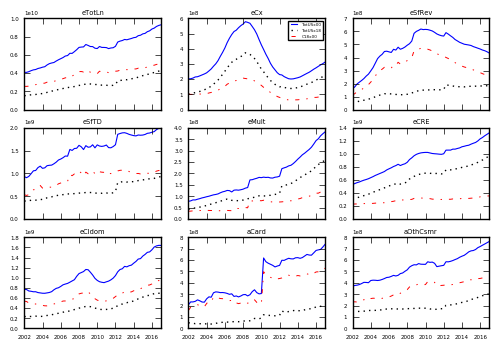

In [84]:
# assumes x18 is second grp, x00 is 1st grp, x31 is third grp:
if len(x3lst) == 3:
  xb = list(bdz3.index)
  plt.rcParams.update({'font.size': 4})

  for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.plot(xb, bdz3[x3lst[0],bcc[i]],c='b',lw=.8,label=x3lst[0][3:])
    plt.plot(xb, bdz3[x3lst[2],bcc[i]],c='k',ls=':',lw=1,label=x3lst[2][3:])
    plt.plot(xb, bdz3[x3lst[1],bcc[i]],c='r',ls='-.',lw=0.7,label=x3lst[1][3:])
    plt.ylim(ymin=0)
    plt.title(bcc[i],y=.97)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False) # force sci notation, zero axis!!
    if i==1: lg = plt.legend(loc=0, fontsize=3)

    if i < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      labelbottom=labl) # labels along the bottom edge are off

  plt.savefig(grp+'_balhist3.png', dpi=400, bbox_inches='tight')
  plt.show()
else:
  print('skip this section')

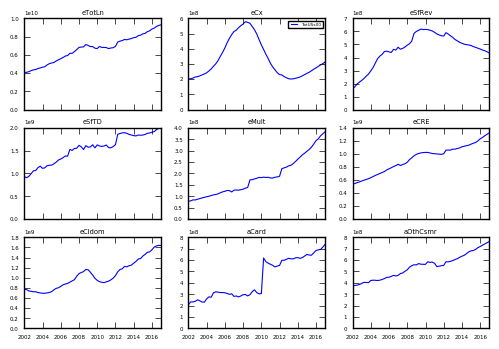

In [85]:
xb = list(bdz3.index)
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xb, bdz3[x3lst[0],bcc[i]],c='b',lw=.8,label=x3lst[0][3:])
  plt.ylim(ymin=0)
  plt.title(bcc[i],y=.97)
  plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False) # force sci notation, zero axis!!
  if i==1: lg = plt.legend(loc=0, fontsize=3)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_balhist1.png', dpi=400, bbox_inches='tight')
plt.show()

In [86]:
bdz3.tail(2)

Grp           grpC18x00                                                     \
                  aCard     aOthCsmr       eCIdom         eCRE         eCx   
AsOf                                                                         
2016-09-30  513644615.0  453805031.0  945792456.0  353512361.0  86196913.0   
2016-12-31  529229075.0  458645139.0  940292415.0  355106569.0  88274920.0   

Grp                                                                         \
                  eMult       eSfRev         eSfTD        eTotLn   rcCIdom   
AsOf                                                                         
2016-09-30  121884391.0  261066947.0  1.065005e+09  5.008942e+09  0.451298   
2016-12-31  125197161.0  251378147.0  1.065713e+09  5.022392e+09  0.456421   

Grp           ...      grpTotUSx31                                          \
              ...           eTotLn   rcCIdom     rcCRE    rcCard      rcCx   
AsOf          ...                                                            
2016-09-30    ...     3.408604e+09  0.414123  0.061893  3.805878 -0.024072   
2016-12-31    ...     3.472501e+09  0.468515  0.041812  4.174461 -0.019976   

Grp                                                           
              rcMult rcOthCsmr   rcSfRev    rcSfTD   rcTotLn  
AsOf                                                          
2016-09-30  0.007610  0.590805  0.104692  0.073560  0.305667  
2016-12-31  0.009913  0.617713  0.085751  0.063891  0.327232  

[2 rows x 90 columns]

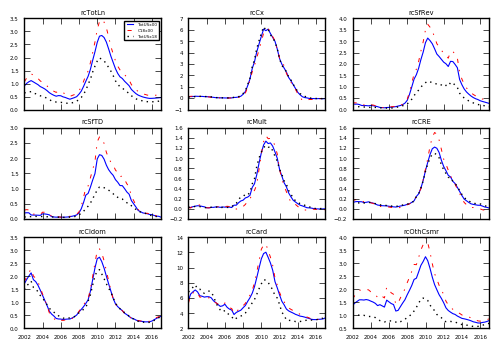

In [87]:
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xb, bdz3[x3lst[0],ncc[i]],c='b',lw=0.8,label=x3lst[0][3:])
  if len(x3lst)>1: plt.plot(xb, bdz3[x3lst[1],ncc[i]],c='r',ls='-.',lw=0.7,label=x3lst[1][3:])
  if len(x3lst)>2: plt.plot(xb, bdz3[x3lst[2],ncc[i]],c='k',ls=':',lw=1,label=x3lst[2][3:])
  plt.title(ncc[i],y=.97)
  if i==0: lg = plt.legend(loc=0, fontsize=3)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_ncohist.png', dpi=400, bbox_inches='tight')
plt.show()

In [88]:
## sections to build stress models for main group: var data in 'hs3' and 'cc3'

In [89]:
##################################################################################
topn = 3 ## IMPORTANT:  topn defines how many among 3-var models are kept in final tables (pick 3 up to 8)
topx = 2 ## denotes max # of 2-var pairs are allowed in final rankings...(pick 1, 2, or 3)
##################################################################################

rclst = ['rcTotLn','rcCx','rcSfRev','rcSfTD','rcMult','rcCRE','rcCIdom','rcCard','rcOthCsmr','rcCREtot']
qclst = ['qcTotLn','qcCx','qcSfRev','qcSfTD','qcMult','qcCRE','qcCIdom','qcCard','qcOthCsmr','qcCREtot']

if qtyp == 1:
  curlst = qclst
elif qtyp == 4:
  curlst = rclst
else:
  curlst = []  # force error if qtyp not 1 or 4

#cbon = vtyp

In [90]:
dfc = df2_3z[df2_3z['Grp']==grp]  #  only copy requested groups in "grp"
dfc.dropna(axis=0, how='any', inplace=True)
dfc.head(2)

AsOf          Grp  IDRSSD   nbr         Cert       eTotAst  \
3 2001-12-31  grpTotUSx00       0  8689  158549775.0  6.886931e+09   
4 2002-03-31  grpTotUSx00       0  8605  157265826.0  6.821466e+09   

         eTotLn       eALLL      eOREO         eGW    ...         eTotrb  \
3  4.087280e+09  74347220.0  4098092.0  79747462.0    ...      12.850678   
4  4.084967e+09  77054630.0  4352285.0  82687154.0    ...      13.110980   

   eALLL_Ln      mxCx   mxSfFst      mxCRE       mxCI    mxCard      mxDDA  \
3  1.818990  4.952527  20.00838  12.972829  22.484685  5.706480  21.539886   
4  1.886298  4.971879  19.56416  13.333594  22.179744  6.080155  19.906120   

     eRWA_TA   lnTotAst  
3  76.567668  22.652891  
4  76.417674  22.643340  

[2 rows x 320 columns]

In [91]:
## sUE_CA2 processing
st=''.join(stlst)
hs3.reset_index(drop=False,inplace=True)
hs3.head(2)

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  Mort  \
0 2000-03-31    1.2    4.3   8.1  11.8  4.0  4.0  5.5  6.6   6.7  8.2   8.3   
1 2000-06-30    7.8   10.2   4.2   6.1  3.9  3.2  5.7  6.5   6.4  8.5   8.3   

   Prime      DJ    HPI    CRE   VIX        CE  
0    8.7  14.296  102.0  125.0  27.0  5.153686  
1    9.2  13.619  105.0  124.0  33.5  5.135663

In [92]:
## parameters for sUE calcs below (by specified CCAR year):
uex = hs3[['Date','UE']].ix[hs3['UE'].idxmax()]
ccp = cc3[['CCAR','Scen','Date','UE']].iloc[cc3.groupby(['CCAR']).apply(lambda x: x['UE'].idxmax())]

def qtn(d):
  return 4*(d.year - 2000) + d.quarter

uex['qtn'] = qtn(uex['Date'])
ccp['qtn'] = ccp.apply(lambda x: qtn(x['Date']), axis=1)

uep = uex['UE']
ccp['adz'] = uep / ccp['UE']
ccp['que'] = uex['qtn']
ccp['pdt'] = uex['Date']


In [93]:
ccps = []

## parameters for sUE_st calcs below (by specified CCAR year):
if len(stlst)>0:
  UE_st = 'UE_'+''.join(stlst)
  uexs = hs3[['Date',UE_st]].ix[hs3[UE_st].idxmax()]
  ccps = cc3[['CCAR','Scen','Date',UE_st]].iloc[cc3.groupby(['CCAR']).apply(lambda x: x[UE_st].idxmax())]

  uexs['qtn'] = qtn(uexs['Date'])
  ccps['qtn'] = ccps.apply(lambda x: qtn(x['Date']), axis=1)

  ueps = uexs[UE_st]
  ccps['adz'] = ueps / ccps[UE_st]
  ccps['que'] = uexs['qtn']
  ccps['pdt'] = uexs['Date']


In [94]:
ccps

[]

In [95]:
ccp

CCAR Scen       Date     UE  qtn       adz  que        pdt
21   2012  Sev 2013-06-30  13.05   54  0.758621   40 2009-12-31
63   2013  Sev 2014-06-30  12.10   58  0.818182   40 2009-12-31
105  2014  Sev 2015-06-30  11.30   62  0.876106   40 2009-12-31
147  2015  Sev 2016-06-30  10.10   66  0.980198   40 2009-12-31
189  2016  Sev 2017-09-30  10.00   71  0.990000   40 2009-12-31
231  2017  Sev 2018-09-30  10.00   75  0.990000   40 2009-12-31

In [96]:
##########################################################################################
# Date selection for desired CCAR year:
# note:  CCAR 2013 implies stress period (9q) of 2012Q4 thru 2014Q4 (altho' scenario data goes thru 2015Q4)
##########################################################################################

ccar = 2017

if ccar <= 2015:
  dtend = pd.to_datetime(str(ccar-1) + '-09-30')  # end date for CCAR history & start date for CCAR forecast
  frend = pd.to_datetime(str(ccar+2) + '-12-31')  # end date for CCAR forecast (13-qtr end date)
else:
  dtend = pd.to_datetime(str(ccar-1) + '-12-31')  # end date for CCAR history & start date for CCAR forecast
  frend = pd.to_datetime(str(ccar+3) + '-03-31')  # end date for CCAR forecast (13-qtr end date)

dtend, frend

(Timestamp('2016-12-31 00:00:00'), Timestamp('2020-03-31 00:00:00'))

In [97]:
## set-up files to analyze CCAR test for a specific year (stored in "ccar" variable):  
ccx = cc3[cc3['CCAR'] == ccar]  # ccx contains forecast periods for selected CCAR start year
ccx = ccx.dropna(axis=1, how='all').reset_index(drop=True)  ## remove var if not included in CCAR list for this year

hsx = hs3.copy()  ## historical macrovars for this run
hsx.tail(5)

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  Mort  \
63 2015-12-31    0.9    1.8   3.0   3.4  5.0  0.8  0.1  1.6   2.2  4.6   3.9   
64 2016-03-31    0.8    1.3   2.1   2.4  4.9 -0.3  0.3  1.4   2.0  4.6   3.7   
65 2016-06-30    1.4    3.7   2.9   5.0  4.9  2.5  0.3  1.3   1.8  4.1   3.6   
66 2016-09-30    3.5    5.0   2.6   4.1  4.9  1.6  0.3  1.2   1.6  3.7   3.4   
67 2016-12-31    3.1    6.1   1.6   4.5  4.7  3.4  0.4  1.7   2.2  4.1   3.9   

    Prime      DJ    HPI    CRE   VIX        CE  
63    3.3  21.101  174.0  277.0  24.4  4.609281  
64    3.5  21.179  177.0  278.0  28.1  4.648969  
65    3.5  21.621  179.0  283.0  25.8  4.650570  
66    3.5  22.469  182.0  290.0  18.1  4.640622  
67    3.5  23.277  183.0  294.0  22.5  4.660609

In [98]:
if vtyp==2:  # indicates sUE2 and sUE3 vars
  ## cycle thru rows of ccx to calc uead factors for sUE calcs:
  hsx['uead'] = 1.0
  ueadz = ccp[ccp['CCAR']==ccar]['adz']
  uepdt = pd.to_datetime(ccp[ccp['CCAR']==ccar]['pdt'])
  uepdtz = pd.to_datetime(ccp[ccp['CCAR']==ccar]['Date'])
  ueinc = (1 - ccp[ccp['CCAR']==ccar]['adz']) / (ccp[ccp['CCAR']==ccar]['qtn'] - ccp[ccp['CCAR']==ccar]['que'])
  #ueadz, uepdt, uepdtz, ueinc
  uead = 1
  for i in np.arange(len(hsx)):
    if (hsx.loc[i,'Date'] <= uepdt).bool():
      pass
    elif (hsx.loc[i,'Date'] >= uepdtz).bool():
      hsx.loc[i,'uead'] = ueadz.item()
    else:
      uead = uead - ueinc
      hsx.loc[i,'uead'] = uead.item()

  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx = ccx.merge(hsx[['Date','uead']],how='left',on='Date')
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx.fillna(method='pad',inplace=True)
  ccx['sUE'] = ccx['UE'] * ccx['uead']
  ccx['sUE2'] = ccx['sUE']**2
  if '3' in styp: ccx['sUE3'] = ccx['sUE']**3
  ccx.drop(['uead','sUE'],axis=1,inplace=True)
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)

  hsx['sUE'] = hsx['UE'] * hsx['uead']
  hsx['sUE2'] = hsx['sUE'] ** 2
  if '3' in styp: hsx['sUE3'] = hsx['sUE'] ** 3
  hsx.drop(['uead','sUE'],axis=1,inplace=True)
  hsx.sort_index(by=['Date'],inplace=True)

ccx.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m    ...      \
40  2017  Sev 2019-12-31    3.9    4.9   2.6   3.8  9.1  1.6  0.1    ...       
41  2017  Sev 2020-03-31    3.9    4.8   2.5   3.6  8.9  1.4  0.1    ...       

    T10y  BBB  Mort  Prime      DJ    HPI    CRE   VIX        CE       sUE2  
40   1.7  3.8   3.9    3.2  21.186  142.0  203.0  14.9  3.565089  81.490340  
41   1.8  3.6   3.8    3.2  22.577  145.0  207.0  14.3  3.510270  77.947709  

[2 rows x 21 columns]

In [99]:
## sUE_st2 & sUE_st3 vars:
if (vtyp==2)&(len(stlst)>0):  # indicates sUE2 and sUE3 vars
  ## cycle thru rows of ccx to calc uead factors for sUE calcs:
  hsx['uead'] = 1.0
  ueadz = ccps[ccps['CCAR']==ccar]['adz']
  uepdt = pd.to_datetime(ccps[ccps['CCAR']==ccar]['pdt'])
  uepdtz = pd.to_datetime(ccps[ccps['CCAR']==ccar]['Date'])
  ueinc = (1 - ccps[ccps['CCAR']==ccar]['adz']) / (ccps[ccps['CCAR']==ccar]['qtn'] - ccps[ccps['CCAR']==ccar]['que'])
  #ueadz, uepdt, uepdtz, ueinc
  uead = 1
  for i in np.arange(len(hsx)):
    if (hsx.loc[i,'Date'] <= uepdt).bool():
      pass
    elif (hsx.loc[i,'Date'] >= uepdtz).bool():
      hsx.loc[i,'uead'] = ueadz.item()
    else:
      uead = uead - ueinc
      hsx.loc[i,'uead'] = uead.item()

  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx = ccx.merge(hsx[['Date','uead']],how='left',on='Date')
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx.fillna(method='pad',inplace=True)
  ccx['sUE_'+''.join(stlst)] = ccx[UE_st] * ccx['uead']
  ccx['sUE_'+''.join(stlst)+'2'] = ccx['sUE_'+''.join(stlst)]**2
  if '3' in styp: ccx['sUE_'+''.join(stlst)+'3'] = ccx['sUE_'+''.join(stlst)]**3
  ccx.drop(['uead','sUE_'+''.join(stlst)],axis=1,inplace=True)
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)

  hsx['sUE_'+''.join(stlst)] = hsx['UE_'+''.join(stlst)] * hsx['uead']
  hsx['sUE_'+''.join(stlst)+'2'] = hsx['sUE_'+''.join(stlst)] ** 2
  if '3' in styp: hsx['sUE_'+''.join(stlst)+'3'] = hsx['sUE_'+''.join(stlst)] ** 3
  hsx.drop(['uead','sUE_'+''.join(stlst)],axis=1,inplace=True)
  hsx.sort_index(by=['Date'],inplace=True)

ccx.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m    ...      \
40  2017  Sev 2019-12-31    3.9    4.9   2.6   3.8  9.1  1.6  0.1    ...       
41  2017  Sev 2020-03-31    3.9    4.8   2.5   3.6  8.9  1.4  0.1    ...       

    T10y  BBB  Mort  Prime      DJ    HPI    CRE   VIX        CE       sUE2  
40   1.7  3.8   3.9    3.2  21.186  142.0  203.0  14.9  3.565089  81.490340  
41   1.8  3.6   3.8    3.2  22.577  145.0  207.0  14.3  3.510270  77.947709  

[2 rows x 21 columns]

In [100]:
## history vars: lag (4q) vars for UE, HPI, CRE:
if vtyp > 0:
  hsx['UE_4'] = hsx['UE'].shift(4)  ## add 4q lag version of UE
  hsx['HPI_4'] = hsx['HPI'].shift(4)
  hsx['CRE_4'] = hsx['CRE'].shift(4)
  hsx['CE_4'] = hsx['CE'].shift(4)

  ccx[['UE_4','HPI_4','CRE_4','CE_4']] = ccx[['UE','HPI','CRE','CE']].shift(4)
  if ccar <= 2015:
    ccx.ix[ccx.Date==str(ccar-1)+'-09-30',['UE_4','HPI_4','CRE_4','CE_4']] =\
          hsx.ix[hsx.Date==str(ccar-2)+'-09-30',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar-1)+'-12-31',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-2)+'-12-31',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar)+'-03-31',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-1)+'-03-31',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar)+'-06-30',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-1)+'-06-30',['UE','HPI','CRE','CE']].values
  if ccar >= 2016:
    ccx.ix[ccx.Date==str(ccar)+'-09-30',['UE_4','HPI_4','CRE_4','CE_4']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-09-30',['UE','HPI','CRE','CE']].values

  if len(stlst)>0: 
    hsx[UE_st +'_4'] = hsx[UE_st].shift(4)  ## add 4q lag version of UE
    hsx['CE_'+''.join(stlst) +'_4'] = hsx['CE_'+''.join(stlst)].shift(4)  ## add 4q lag version of UE
    ccx[UE_st+'_4'] = ccx[UE_st].shift(4)
    ccx['CE_'+''.join(stlst) +'_4'] = ccx['CE_'+''.join(stlst)].shift(4)
    if ccar <= 2015:
      ccx.ix[ccx.Date==str(ccar-1)+'-09-30',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
            hsx.ix[hsx.Date==str(ccar-2)+'-09-30',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar-1)+'-12-31',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-2)+'-12-31',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar)+'-03-31',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-03-31',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar)+'-06-30',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-06-30',[UE_st,'CE_'+''.join(stlst)]].values
    if ccar >= 2016:
      ccx.ix[ccx.Date==str(ccar)+'-09-30',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
            hsx.ix[hsx.Date==str(ccar-1)+'-09-30',[UE_st,'CE_'+''.join(stlst)]].values

  ## double check CE, cest, uest vars on boundary date bet hist and forecast (9/30/ccyr-1)
  if ccar <= 2015:
    ccx.ix[ccx.Date==str(ccar-1)+'-09-30',['CE']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-09-30',['CE']].values
  else:
    ccx.ix[ccx.Date==str(ccar-1)+'-12-31',['CE']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-12-31',['CE']].values

#hsx.dropna(how='any', inplace=True)
hsx.tail()

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y    ...     \
63 2015-12-31    0.9    1.8   3.0   3.4  5.0  0.8  0.1  1.6   2.2    ...      
64 2016-03-31    0.8    1.3   2.1   2.4  4.9 -0.3  0.3  1.4   2.0    ...      
65 2016-06-30    1.4    3.7   2.9   5.0  4.9  2.5  0.3  1.3   1.8    ...      
66 2016-09-30    3.5    5.0   2.6   4.1  4.9  1.6  0.3  1.2   1.6    ...      
67 2016-12-31    3.1    6.1   1.6   4.5  4.7  3.4  0.4  1.7   2.2    ...      

        DJ    HPI    CRE   VIX        CE       sUE2  UE_4  HPI_4  CRE_4  \
63  21.101  174.0  277.0  24.4  4.609281  24.658318   5.7  165.0  253.0   
64  21.179  177.0  278.0  28.1  4.648969  23.668225   5.6  168.0  262.0   
65  21.621  179.0  283.0  25.8  4.650570  23.654605   5.4  170.0  266.0   
66  22.469  182.0  290.0  18.1  4.640622  23.640989   5.2  172.0  272.0   
67  23.277  183.0  294.0  22.5  4.660609  21.737974   5.0  174.0  277.0   

        CE_4  
63  4.475914  
64  4.509920  
65  4.540486  
66  4.558844  
67  4.609281  

[5 rows x 23 columns]

In [101]:
ccs = ccx.copy()  # CCAR scenarios for selected year
cccol = list(ccx.columns[3:])  # list of all CCAR variables to analyze
if 'No' in irflg:
  cccol = [x for x in cccol if x not in xvr] 

Xcol = ['Intercept'] + cccol  # model variables using intercept & all CCAR variables

hsx = hsx[['Date']+cccol]  ## align var columns between hist and ccar lists (& remove forecast rows)
hsz = hsx[hsx['Date']<=frend].merge(dfc[['Grp','IDRSSD','AsOf']+curlst],\
                                    how='left',left_on='Date',right_on='AsOf') # merge hs and df data
### remove any rows with missing data:
hsz.dropna(how='any',inplace=True)
hsy = hsz[hsz['Date']<=dtend]  # cut off table at end of history: (ccar_yr-1)-09-30... use this to build models

ccs['Intercept'] = 1.0  # to set up fitting model

hsz['Intercept'] = 1.0   # to set up fitting for all available history

In [102]:
#######################################################
# 12/13/15: added new code for "big3" variables:
#######################################################
cccol3 = []
if ('Big' in irflg)|('big' in irflg):
  for i in np.arange(len(big3)):
    cccol3 = cccol3 + [x for x in cccol if big3[i] in x]
  cccol = cccol3
  Xcol = ['Intercept'] + cccol

cccol = [x for x in cccol if x[-1]!='3']
Xcol = [x for x in Xcol if x[-1]!='3']
Xcol

['Intercept',
 'rGDPg',
 'nGDPg',
 'rDIg',
 'nDIg',
 'UE',
 'CPI',
 'DJ',
 'HPI',
 'CRE',
 'VIX',
 'CE',
 'sUE2',
 'UE_4',
 'HPI_4',
 'CRE_4',
 'CE_4']

In [103]:
## model:  du003edb...
## start full model here:

In [104]:
# start full model loop here:
for rc in curlst:
  eqn = rc + " ~ " + " + ".join(cccol)
  yt, Xt = dmatrices(eqn , data=hsy, return_type='dataframe')
  mod = sm.OLS(yt, Xt)
  res_tot = mod.fit()
  pred_tot = res_tot.predict(Xt)
  p_tot = res_tot.predict(ccs[Xcol])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt.rename(columns = {rc : 'Actual'}, inplace=True)
  frt['Fit'] = res_tot.predict(hsz[Xcol])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.rename(columns = {'pred' : 'Base'}, inplace=True)
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='left',on='Date')
  frt.rename(columns = {'pred' : 'Adverse'}, inplace=True)
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='left',on='Date')
  frt.rename(columns = {'pred' : 'SevAdv'}, inplace=True)
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()
  frt2.columns = [[rc]*len(frt.columns),frt.columns]

  prm = res_tot.params
  prm['rsq'] = res_tot.rsquared
  prm2 = pd.DataFrame(prm)
  prm2.columns = [rc]

  if rc == curlst[0]:
    frt3 = frt2.copy()
    prm3 = prm2.copy()
  else:
    frt3 = frt3.merge(frt2, how='left', left_index=True, right_index=True)
    prm3 = prm3.merge(prm2, how='left', left_index=True, right_index=True)


In [105]:
frt3.to_csv(grp + "_" + str(ccar) + "_full_fcst_" + str(qtyp) + "q_" + styp + irflg + ".csv")
prm3.to_csv(grp + "_" + str(ccar) + "_full_param_" + str(qtyp) + "q_" + styp + irflg + ".csv")
ccar, grp, styp, irflg

(2017, 'grpTotUSx00', 'Lags_sUE2', '_NoRates')

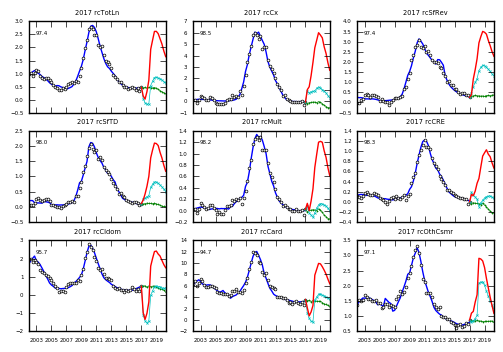

In [106]:
xax = list(frt3.index)
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt3[curlst[i],'Actual'],ls='-',c='b',lw=1)
  plt.plot(xax,frt3[curlst[i],'Fit'],ls='None', marker='o',c='w',ms=2)
  plt.plot(xax,frt3[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.5)
  plt.plot(xax,frt3[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.5,c='c')
  plt.plot(xax,frt3[curlst[i],'SevAdv'],ls='-',c='r',lw=1)
  plt.title(str(ccar)+" "+curlst[i])
  plt.annotate(str(round(prm3.ix['rsq'][curlst[i]]*100,1)), xy=(0.05, 0.86), xycoords='axes fraction', fontsize=4)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+"_"+str(ccar)+'_full'+str(qtyp) + "q_"+styp+irflg+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [107]:
prm3

rcTotLn      rcCx   rcSfRev    rcSfTD    rcMult     rcCRE  \
Intercept  2.695333  1.313865 -0.161688 -1.092501  0.180895  2.368667   
rGDPg     -0.068378 -0.197789 -0.024437 -0.044091 -0.039588 -0.032985   
nGDPg      0.057367  0.147444 -0.005328  0.028596  0.031703  0.023749   
rDIg       0.068752  0.084595  0.012413  0.012147  0.006470  0.003885   
nDIg      -0.062946 -0.079185 -0.020439 -0.013251 -0.003916 -0.004482   
UE        -1.461301 -3.595821 -0.337908 -0.771441 -1.006995 -0.786972   
CPI        0.034536  0.025809  0.006469  0.001524  0.001525  0.001313   
DJ         0.028804  0.007938 -0.039749  0.000832  0.022502 -0.006035   
HPI       -0.009995 -0.038386 -0.010546 -0.010923 -0.010532 -0.010972   
CRE        0.001724  0.004980 -0.001074  0.000620  0.001329  0.002148   
VIX        0.004458  0.003019 -0.009863 -0.002506  0.003250 -0.001019   
CE        -0.336992  1.981874 -0.321650  0.322152  0.485959  0.439605   
sUE2       0.116469  0.318889  0.042307  0.069501  0.082886  0.062955   
UE_4       0.186280  0.470526  0.266422  0.229002  0.146142  0.110043   
HPI_4     -0.010754  0.002570  0.006526 -0.001924  0.000620  0.003373   
CRE_4      0.001257  0.010628  0.007687  0.005749  0.001142 -0.000555   
CE_4       1.030486 -0.268731  0.333486  0.273485  0.048999 -0.339309   
rsq        0.974394  0.985417  0.973908  0.980337  0.982316  0.982871   

             rcCIdom    rcCard  rcOthCsmr  rcCREtot  
Intercept  11.127005 -7.013888 -10.996822 -0.180205  
rGDPg      -0.044724 -0.264850  -0.017325 -0.078591  
nGDPg       0.053801  0.241759   0.017407  0.060513  
rDIg        0.066814  0.265359   0.007757  0.054634  
nDIg       -0.057944 -0.223619  -0.000607 -0.051022  
UE         -1.927482 -4.972525  -0.041285 -1.283609  
CPI         0.028559  0.140737   0.015443  0.022485  
DJ          0.042013  0.292759   0.061015  0.022651  
HPI        -0.008600 -0.015120  -0.002453 -0.013571  
CRE        -0.001672  0.006437   0.000073  0.001621  
VIX         0.009030  0.039266   0.008127  0.002630  
CE         -2.159757 -0.345678   0.347358  0.530385  
sUE2        0.129382  0.410084   0.027404  0.114905  
UE_4        0.013776  0.786441   0.196496  0.180561  
HPI_4      -0.017751 -0.082257  -0.015570 -0.000151  
CRE_4      -0.003390  0.003100   0.007048  0.002947  
CE_4        2.250847  6.255380   1.808960  0.204213  
rsq         0.956980  0.946730   0.971378  0.982037

In [108]:
### build 3-var models:

In [109]:
def df1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

df1 = pd.DataFrame(columns=['rc','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for rc in curlst:
  for v in cccol:
    y, X = dmatrices( rc + ' ~ ' + v , data=hsy, return_type='dataframe')
    mod = sm.OLS(y, X)
    res = mod.fit()
    df1 = df1.append({'rc': rc,'v1': v, 'r1': res.rsquared_adj}, ignore_index=True)

df1g = df1.groupby(['rc'])
df1t = df1g.apply(df1_topx)
df1t.index = np.arange(len(df1t))

# stores r-sq values for all 2-var combos:
df2 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'rc','x', 'y'}))  # to retain processed var-pairs

for idx, row in df1t.iterrows():
  for v in cccol:
    if (row['v1'] == v) | ({row['rc'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df2 = df2.append({'rc':row['rc'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.rsquared_adj}, ignore_index=True)
      st2.add(frozenset({row['rc'], v, row['v1']}))

In [110]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = df2.groupby(['rc','v1'])
df2a = grouped.apply(get_topx_2var)
df2a = df2a.sort_index(by=['rc','r2','r1'], ascending=[True,False,False])
df2a.index = np.arange(len(df2a))

# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
df3 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cf3 = pd.DataFrame(columns=['Int','c1','c2','c3'])
st3 = set(frozenset({'rc','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df2a.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['rc'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df3 = df3.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],'v3':v,\
                        'r3': res.rsquared_adj},ignore_index=True)
      st3.add(frozenset({row['rc'],v, row['v1'], row['v2']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3']
      cf3 = cf3.append(cm.ix[0])

cf3 = cf3.reset_index(drop=True)
df3 = df3.reset_index(drop=True)
df3 = df3.merge(cf3, how='inner', left_index=True, right_index=True)

In [111]:
# function to select top 3 for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

df3g = df3.groupby(['rc','v1','v2'])  #  allows topx for each primary 2-var pair
df3a = df3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
df3ag = df3a.groupby(['rc'])  # prep to find topn best models for each product category
df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
df3b.index = np.arange(len(df3b))

In [112]:
### sections to generate forecasts for all 3-var models:

for idx, row in df3b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt['Fit'] = res_c.predict(hsz[pvar])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base']
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse']
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()

  frt2.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] # use this if using top3_rc

  if x == 0:
    frt3b = frt2.copy()
  else:
    frt3b = frt3b.merge(frt2, how='outer', left_index=True, right_index=True)

In [113]:
frt3s = pd.DataFrame(frt3b.ix[str(ccar-1)+'-12-31':str(ccar+1)+'-12-31'].sum())
frt3s.reset_index(drop=False, inplace=True)
frt3s.columns = ['rc','scen','amt']
frpv = pd.pivot_table(frt3s,index='rc',columns='scen',values='amt')
frpv.reset_index(drop=False, inplace=True)
frpv['rc2'] = frpv.apply(lambda x: x['rc'][:-1], axis=1)
dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
frpv['ord'] = frpv.apply(lambda x: dlst[x['rc2']], axis=1)
frpv['diff'] = frpv['SevAdv']  ## can sort using SevAdv only, or by SevAdv - Base
#frpv['diff'] = frpv['SevAdv'] - frpv['Base']  ## SevAdv - Base differential
#frpv.sort_index(by=['ord','diff'], ascending=[True,False], inplace=True)
frpv.reset_index(drop=True, inplace=True)
frpv['rk'] = frpv.index % topn + 1
frpv.sort_index(by=['ord','rc'], ascending=True, inplace=True)
frpv.reset_index(drop=True, inplace=True)
frpv.head(8)

scen        rc    Actual    Adverse      Base       Fit     SevAdv      rc2  \
0     rcTotLn0  0.464722   7.839375  1.570141  0.220882  14.717673  rcTotLn   
1     rcTotLn1  0.464722   7.801899  3.267619  0.373316  15.443443  rcTotLn   
2     rcTotLn2  0.464722   7.816402  0.786675  0.161698  14.507683  rcTotLn   
3        rcCx0 -0.030257   6.306147  0.114311  0.014945  31.568788     rcCx   
4        rcCx1 -0.030257   7.587184  0.491624 -0.049023  32.990232     rcCx   
5        rcCx2 -0.030257  14.162103 -5.105410 -0.550632  34.823938     rcCx   
6     rcSfRev0  0.271345  11.438045  2.679159  0.290061  20.529453  rcSfRev   
7     rcSfRev1  0.271345  11.591107  2.142837  0.243562  20.609997  rcSfRev   

scen  ord       diff  rk  
0       0  14.717673   1  
1       0  15.443443   2  
2       0  14.507683   3  
3       1  31.568788   1  
4       1  32.990232   2  
5       1  34.823938   3  
6       2  20.529453   1  
7       2  20.609997   2

In [114]:
df3bc = df3b.copy()
df3bc.rename(columns={'rc' : 'rc2'}, inplace=True)
df3bc['rc'] = df3bc.index % topn
df3bc['rc'] = df3bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
df3bc = df3bc.merge(frpv[['rc','ord','rk']], on='rc', how='left')
df3bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
df3bc.reset_index(drop=True, inplace=True)
df3bc.index.names = [grp+"_"+str(ccar)+"_"+styp]
df3bc.tail()

rc2    v1        r1     v2        r2     v3  \
grpTotUSx00_2017_Lags_sUE2                                                      
25                          rcOthCsmr  sUE2  0.379897   CE_4  0.936075  CRE_4   
26                          rcOthCsmr  sUE2  0.379897     CE  0.818828   UE_4   
27                           rcCREtot  sUE2  0.902125     UE  0.945036    VIX   
28                           rcCREtot  sUE2  0.902125     UE  0.945036  rGDPg   
29                           rcCREtot  sUE2  0.902125  HPI_4  0.931274     DJ   

                                  r3       Int        c1        c2        c3  \
grpTotUSx00_2017_Lags_sUE2                                                     
25                          0.943216 -5.125007  0.027121  1.060029  0.001452   
26                          0.901622 -2.856068  0.040212  0.805221 -0.202656   
27                          0.957484  2.525616  0.099994 -1.023502  0.007442   
28                          0.955797  2.713120  0.099988 -1.011162 -0.033013   
29                          0.942335 -1.657808  0.031351  0.007423 -0.020612   

                                    rc  ord  rk  
grpTotUSx00_2017_Lags_sUE2                       
25                          rcOthCsmr1    8   2  
26                          rcOthCsmr2    8   3  
27                           rcCREtot0    9   1  
28                           rcCREtot1    9   2  
29                           rcCREtot2    9   3

In [115]:
frt3b.to_csv(grp + "_"  + str(ccar) +'_3v_9fcst_' + str(qtyp) + "q_" + styp +irflg + '.csv')
df3bc.to_csv(grp + "_"  + str(ccar) + '_3v_9param_' + str(qtyp) + "q_" + styp +irflg + '.csv')
ccar

2017

In [116]:
rnk = 1  ## 1 to topn

df_bst = df3bc[df3bc['rk']== rnk][['rc','v1','v2','v3','r3']]
df_bst.dropna(how='any', inplace=True)
df_bst.reset_index(drop=True, inplace=True)

def vlst(x):
  lst = [x['v1'],x['v2'],x['v3'],str(round(x['r3']*100,1))]
  return ';'.join(lst)

df_bst['var'] = df_bst.apply(vlst, axis=1)
dflst = list(df_bst['var'])
#dflst2 = [dflst[i] for i in grord]
dflst

['sUE2;CE_4;HPI;91.7',
 'sUE2;UE;VIX;95.9',
 'UE;HPI_4;CE;95.8',
 'sUE2;HPI_4;HPI;95.6',
 'sUE2;UE;UE_4;92.4',
 'sUE2;UE_4;UE;92.0',
 'CRE;sUE2;UE_4;79.7',
 'sUE2;CE_4;HPI_4;85.6',
 'sUE2;CE_4;CE;95.0',
 'sUE2;UE;VIX;95.7']

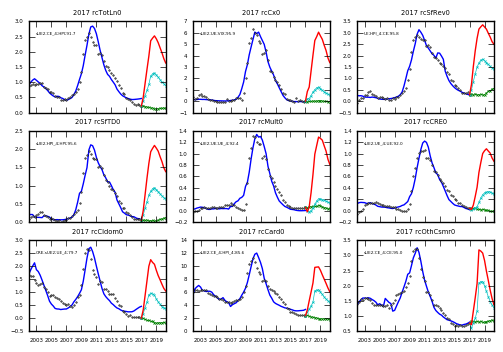

In [117]:
plt.rcParams.update({'font.size': 4})

#j = 0

for i in np.arange(len(dflst[0:9])):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Actual'],ls='-',c='b',lw=1)
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Base'],ls='-',lw=.5,marker='x',ms=1.5,c='g')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Adverse'],ls='-',lw=.5,marker='x',ms=1.5,c='c')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'SevAdv'],ls='-',c='r',lw=1)
  plt.annotate(dflst[i], xy=(0.05, 0.86), xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.title(str(ccar)+" "+df_bst.ix[i]['rc'])
  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [118]:
grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'.png'

'grpTotUSx00_2017_4q_3v9n_Lags_sUE2_3rk1_NoRates.png'

In [119]:
frt3b.ix[:'2012-09-30'][df_bst.ix[i]['rc'],'Actual'][-4:]

Date
2011-12-31    1.485802
2012-03-31    1.290726
2012-06-30    1.189177
2012-09-30    1.125011
Name: (rcOthCsmr0, Actual), dtype: float64

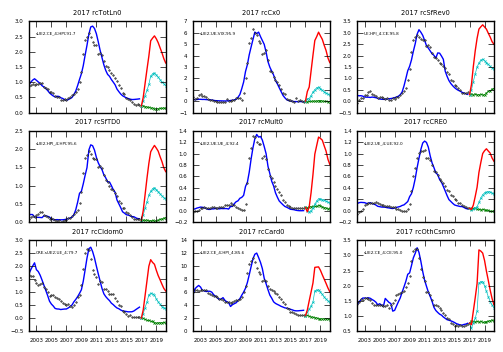

In [120]:
# alt version cuts off act and fit before 1st CCAR forecast period
plt.rcParams.update({'font.size': 4})
xaz=list(frt3b.ix[:str(ccar-1)+'-09-30'].index)
#j = 0

for i in np.arange(len(dflst[0:9])):
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt3b.ix[:str(ccar-1)+'-09-30'][df_bst.ix[i]['rc'],'Actual'],ls='-',c='b',lw=1)
  plt.plot(xaz,frt3b.ix[:str(ccar-1)+'-09-30'][df_bst.ix[i]['rc'],'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Base'],ls='-',lw=.5,marker='x',ms=1.5,c='g')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Adverse'],ls='-',lw=.5,marker='x',ms=1.5,c='c')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'SevAdv'],ls='-',c='r',lw=1)
  plt.annotate(dflst[i], xy=(0.05, 0.86), xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.title(str(ccar)+" "+df_bst.ix[i]['rc'])
  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'alt.png', dpi=400, bbox_inches='tight')
plt.show()

In [121]:
df3lst = []
for i in np.arange(len(df3bc)):
  ds = df3bc.ix[i]['v1'] + ', ' + df3bc.ix[i]['v2'] + ', ' + df3bc.ix[i]['v3'] +\
         ': '+ str(round(df3bc.ix[i]['r3']*100,1))
  df3lst = df3lst + [ds]

df3bc['Annot'] = df3lst
df3bc[0:2]

rc2    v1        r1    v2        r2   v3  \
grpTotUSx00_2017_Lags_sUE2                                                 
0                           rcTotLn  sUE2  0.866796  CE_4  0.909891  HPI   
1                           rcTotLn  sUE2  0.866796  CE_4  0.909891   UE   

                                  r3       Int        c1        c2        c3  \
grpTotUSx00_2017_Lags_sUE2                                                     
0                           0.916764 -1.108352  0.027404  0.308684 -0.003767   
1                           0.915024 -0.117481  0.056799  0.242426 -0.396023   

                                  rc  ord  rk                  Annot  
grpTotUSx00_2017_Lags_sUE2                                            
0                           rcTotLn0    0   1  sUE2, CE_4, HPI: 91.7  
1                           rcTotLn1    0   2   sUE2, CE_4, UE: 91.5

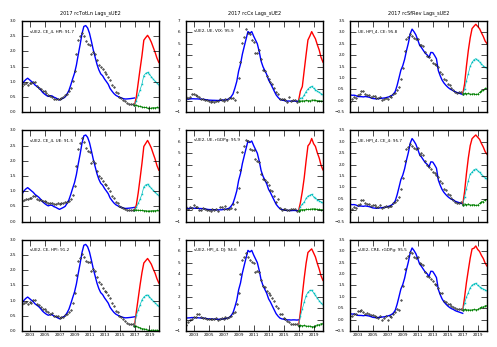

In [122]:
## top3 3-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

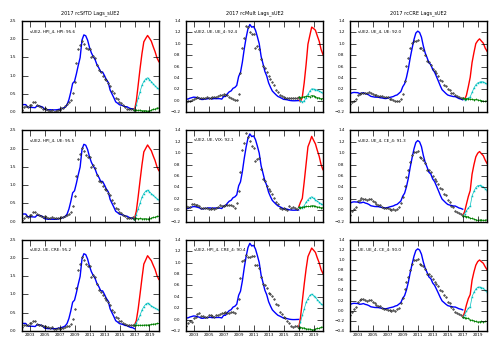

In [123]:
## top3 3-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

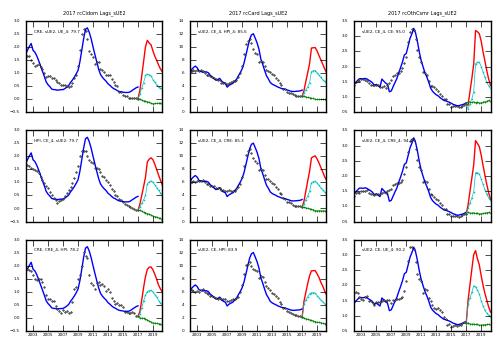

In [124]:
## top3 3-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [125]:
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
df4 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cf4 = pd.DataFrame(columns=['Int','c1','c2','c3','c4'])
st4 = set(frozenset({'rc','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df3b.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['rc'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['rc']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v,\
                       data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df4 = df4.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                        'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.rsquared_adj},ignore_index=True)
      st4.add(frozenset({row['rc'],v, row['v1'], row['v2'], row['v3']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3','c4']
      cf4 = cf4.append(cm.ix[0])

cf4 = cf4.reset_index(drop=True)
df4 = df4.reset_index(drop=True)
df4 = df4.merge(cf4, how='inner', left_index=True, right_index=True)

In [126]:
# function to select top 3 for each lead variable:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topx]

def get_topn_4rc(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topn]

df4g = df4.groupby(['rc','v1','v2','v3'])  #  allows topx for each primary 2-var pair
df4a = df4g.apply(get_topx_4var)  ## finds best topx models from each 3-var combo
df4ag = df4a.groupby(['rc'])  # prep to find topn best models for each product category
df4b = df4ag.apply(get_topn_4rc)  # find topn models among all 3-var models
df4b.index = np.arange(len(df4b))

In [127]:
### sections to generate forecasts for all 4-var models:

for idx, row in df4b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt['Fit'] = res_c.predict(hsz[pvar])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base']
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse']
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()

  frt2.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] ## sets up level0 column group names

  if x == 0:
    frt4b = frt2.copy()
  else:
    frt4b = frt4b.merge(frt2, how='outer', left_index=True, right_index=True)

In [128]:
frt2.head()

rcTotLn2                              
              Actual       Fit Base Adverse SevAdv
Date                                              
2001-12-31  0.906950  0.911264  NaN     NaN    NaN
2002-03-31  1.003935  0.929438  NaN     NaN    NaN
2002-06-30  1.068781  0.936712  NaN     NaN    NaN
2002-09-30  1.114087  0.911303  NaN     NaN    NaN
2002-12-31  1.063023  0.932339  NaN     NaN    NaN

In [129]:
frt4s = pd.DataFrame(frt4b.ix[str(ccar-1)+'-12-31':str(ccar+1)+'-12-31'].sum())
frt4s.reset_index(drop=False, inplace=True)
frt4s.columns = ['rc','scen','amt']
frpv = pd.pivot_table(frt4s,index='rc',columns='scen',values='amt')
frpv.reset_index(drop=False, inplace=True)
frpv['rc2'] = frpv.apply(lambda x: x['rc'][:-1], axis=1)
dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
frpv['ord'] = frpv.apply(lambda x: dlst[x['rc2']], axis=1)
####################################################################
#   NOTE:  this section will determine ordering of models in charts:
#          3 options: (1) r-sq, (2) SevAdv, or (3) differential bet SevAdv and Base
#frpv['diff'] = frpv['SevAdv']  ## can sort using SevAdv only, or by SevAdv - Base
frpv['diff'] = frpv['SevAdv'] - frpv['Base']  ## SevAdv - Base differential
#frpv['diff'] = frpv.apply(lambda x: x['SevAdv']-max(0,x['Base']),axis=1)
#frpv['diff'] = frpv['rc']  # this will rank models by r-sq values
####################################################################
frpv.sort_index(by=['ord','diff'], ascending=[True,False], inplace=True) # use for diff = SevAdv or SevAdv-Base
#frpv.sort_index(by=['ord','diff'], ascending=[True,True], inplace=True)  # use for diff=rc only
####################################################################
frpv.reset_index(drop=True, inplace=True)
frpv['rk'] = frpv.index % topn
frpv.sort_index(by=['ord','rc'], ascending=True, inplace=True)
frpv.tail(9)

scen          rc    Actual    Adverse       Base       Fit     SevAdv  \
23       rcCard0  3.379670  32.529120  27.359473  3.162670  58.682022   
22       rcCard1  3.379670  33.193996  27.040636  3.120448  60.264214   
21       rcCard2  3.379670  33.572292  22.829111  2.695249  60.831090   
24    rcOthCsmr0  0.806481  14.070499   7.318333  0.798990  19.498797   
25    rcOthCsmr1  0.806481  12.666933   7.117634  0.760872  18.733941   
26    rcOthCsmr2  0.806481  12.451749   7.644237  0.811133  18.313524   
29     rcCREtot0  0.005961   2.222108   0.542256  0.068339  11.848584   
28     rcCREtot1  0.005961   3.552433   0.599935  0.060456  12.944424   
27     rcCREtot2  0.005961   3.453257   0.549203  0.049632  13.097554   

scen        rc2  ord       diff  rk  
23       rcCard    7  31.322548   2  
22       rcCard    7  33.223579   1  
21       rcCard    7  38.001979   0  
24    rcOthCsmr    8  12.180464   0  
25    rcOthCsmr    8  11.616307   1  
26    rcOthCsmr    8  10.669287   2  
29     rcCREtot    9  11.306327   2  
28     rcCREtot    9  12.344490   1  
27     rcCREtot    9  12.548352   0

In [130]:
df4bc = df4b.copy()
df4bc.rename(columns={'rc' : 'rc2'}, inplace=True)
df4bc['rc'] = df4bc.index % topn
df4bc['rc'] = df4bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
df4bc = df4bc.merge(frpv[['rc','ord','rk']], on='rc', how='left')
df4bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
df4bc.reset_index(drop=True, inplace=True)
df4bc['Desc'] = grp+"_"+str(ccar)+"_4v9"+styp
df4bc.tail(9)

rc2    v1        r1    v2        r2     v3        r3     v4  \
21     rcCard  sUE2  0.597593  CE_4  0.814858  HPI_4  0.855517     UE   
22     rcCard  sUE2  0.597593    CE  0.817149    HPI  0.838980     UE   
23     rcCard  sUE2  0.597593  CE_4  0.814858    CRE  0.852654     UE   
24  rcOthCsmr  sUE2  0.379897  CE_4  0.936075  CRE_4  0.943216  HPI_4   
25  rcOthCsmr  sUE2  0.379897  CE_4  0.936075     CE  0.950358    VIX   
26  rcOthCsmr  sUE2  0.379897  CE_4  0.936075     CE  0.950358  nGDPg   
27   rcCREtot  sUE2  0.902125    UE  0.945036    VIX  0.957484   UE_4   
28   rcCREtot  sUE2  0.902125    UE  0.945036    VIX  0.957484  HPI_4   
29   rcCREtot  sUE2  0.902125    UE  0.945036  rGDPg  0.955797  nGDPg   

          r4        Int        c1        c2        c3        c4          rc  \
21  0.900739  11.724210  0.369939  2.090340 -0.038919 -4.141768     rcCard0   
22  0.898817  18.495322  0.443096  1.929499 -0.051182 -5.241104     rcCard1   
23  0.881417  11.428704  0.292830  1.074314 -0.017880 -3.147666     rcCard2   
24  0.951415  -5.144684  0.026307  1.147000  0.003418 -0.004954  rcOthCsmr0   
25  0.950910  -3.673478  0.021000  1.438367 -0.580909  0.002462  rcOthCsmr1   
26  0.950813  -3.417091  0.019863  1.634650 -0.815313  0.010122  rcOthCsmr2   
27  0.960947   2.791136  0.107879 -1.180398  0.010071  0.050681   rcCREtot0   
28  0.959015   1.669012  0.089922 -0.867108  0.006895  0.002052   rcCREtot1   
29  0.957306   2.523016  0.098383 -0.981093 -0.073526  0.037220   rcCREtot2   

    ord  rk                           Desc  
21    7   2  grpTotUSx00_2017_4v9Lags_sUE2  
22    7   1  grpTotUSx00_2017_4v9Lags_sUE2  
23    7   0  grpTotUSx00_2017_4v9Lags_sUE2  
24    8   0  grpTotUSx00_2017_4v9Lags_sUE2  
25    8   1  grpTotUSx00_2017_4v9Lags_sUE2  
26    8   2  grpTotUSx00_2017_4v9Lags_sUE2  
27    9   2  grpTotUSx00_2017_4v9Lags_sUE2  
28    9   1  grpTotUSx00_2017_4v9Lags_sUE2  
29    9   0  grpTotUSx00_2017_4v9Lags_sUE2

In [131]:
frt4b.to_csv(grp + "_"  + str(ccar) +'_4v_9fcst_' + str(qtyp) + "q_" + styp +irflg + '.csv')
df4bc.to_csv(grp + "_"  + str(ccar) + '_4v_9param_' + str(qtyp) + "q_" + styp +irflg + '.csv')
ccar

2017

In [132]:
df4lst1 = []
df4lst2 = []
for i in np.arange(len(df4bc)):
  ds1 = df4bc.ix[i]['v1'] + ', ' + df4bc.ix[i]['v2'] + ', ' + df4bc.ix[i]['v3'] + ','
  ds2 = df4bc.ix[i]['v4'] +': '+ str(round(df4bc.ix[i]['r4']*100,1))
  df4lst1 = df4lst1 + [ds1]
  df4lst2 = df4lst2 + [ds2]

df4bc['Annot1'] = df4lst1
df4bc['Annot2'] = df4lst2
df4bc[0:2]

rc2    v1        r1    v2        r2   v3        r3  v4        r4  \
0  rcTotLn  sUE2  0.866796  CE_4  0.909891  HPI  0.916764  UE  0.953608   
1  rcTotLn  sUE2  0.866796    CE  0.904350  HPI  0.911890  UE  0.953481   

        Int        c1        c2        c3        c4        rc  ord  rk  \
0  5.631018  0.109980  0.080729 -0.010979 -1.266404  rcTotLn0    0   2   
1  5.624167  0.112326  0.098694 -0.011156 -1.290287  rcTotLn1    0   1   

                            Desc            Annot1    Annot2  
0  grpTotUSx00_2017_4v9Lags_sUE2  sUE2, CE_4, HPI,  UE: 95.4  
1  grpTotUSx00_2017_4v9Lags_sUE2    sUE2, CE, HPI,  UE: 95.3

In [133]:
##################################################################################
# select highest R-squared model:
#md = [0,0,0,0,0,0,0,0,0]  # note: use this to rank based on R-squared
#mdr = [x for x in list(df4bc['rc']) if x[-1]=='0']

# special code to select "best" model based on max 9q diff between SevAdv and Base forecasts:
md=list(df4bc[df4bc['rk']==0]['rc'])  # note: use this if you want models based on diff calc (SevAdv - Bas ranking)
mdr = [x[-1] for x in md]

mdr, md

(['2', '1', '2', '0', '2', '2', '1', '2', '0', '2'],
 ['rcTotLn2',
  'rcCx1',
  'rcSfRev2',
  'rcSfTD0',
  'rcMult2',
  'rcCRE2',
  'rcCIdom1',
  'rcCard2',
  'rcOthCsmr0',
  'rcCREtot2'])

In [134]:
curlst

['rcTotLn',
 'rcCx',
 'rcSfRev',
 'rcSfTD',
 'rcMult',
 'rcCRE',
 'rcCIdom',
 'rcCard',
 'rcOthCsmr',
 'rcCREtot']

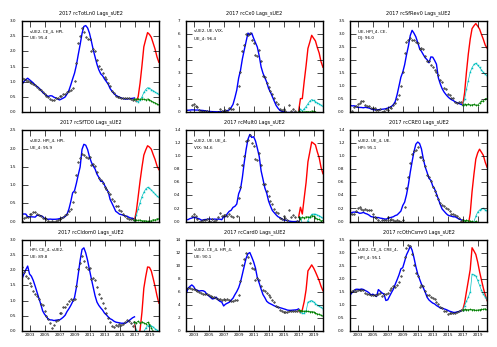

In [135]:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=1,label='History')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_'+str(ver)+irflg +'.png', dpi=400, bbox_inches='tight')
plt.show()

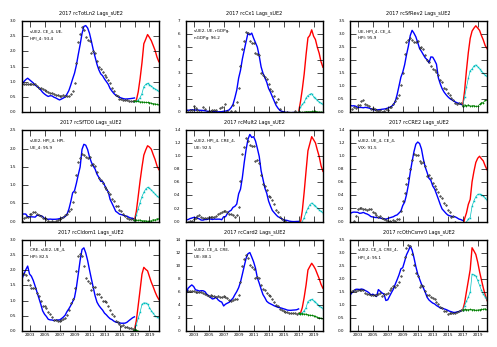

In [136]:
## special version for TotUSx18 only... best version based on diff bet SevAdv and Base:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

#ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  ver = mdr[i]
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=1,label='History')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_bestdiff'+irflg +'.png', dpi=400, bbox_inches='tight')
plt.show()

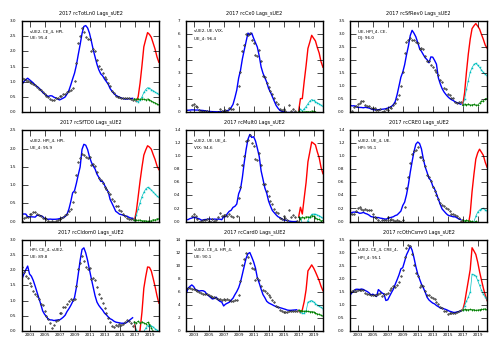

In [137]:
# alt cuts off act and fit before forecast starts:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=1,label='History')
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_'+str(ver)+irflg +'alt.png', dpi=400, bbox_inches='tight')
plt.show()

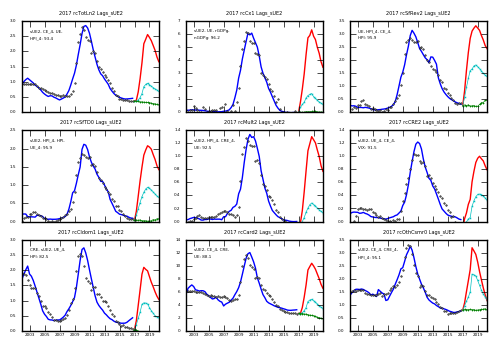

In [138]:
## special version for 2013 TotUSx18 only... best diff sevadv - base (9q only)
# alt cuts off act and fit before forecast starts:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

for i in np.arange(9):
  ver = mdr[i]
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=1,label='History')
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.ylim(ymin=0)

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_bestdiff'+irflg +'alt.png', dpi=400, bbox_inches='tight')
plt.show()

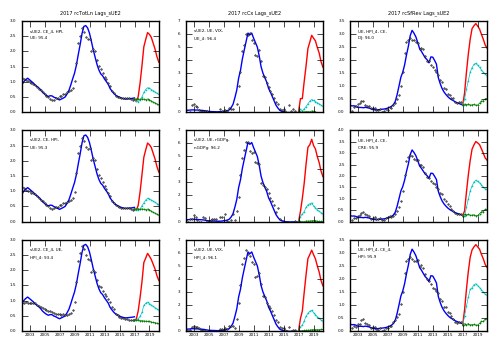

In [139]:
## top3 4-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

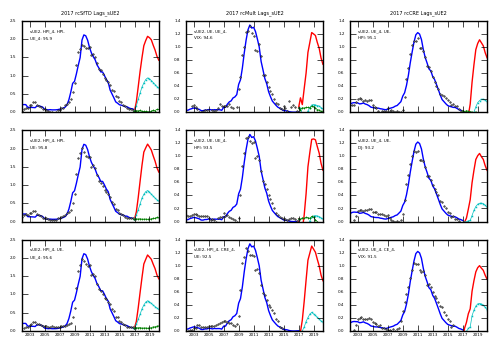

In [140]:
## top3 4-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

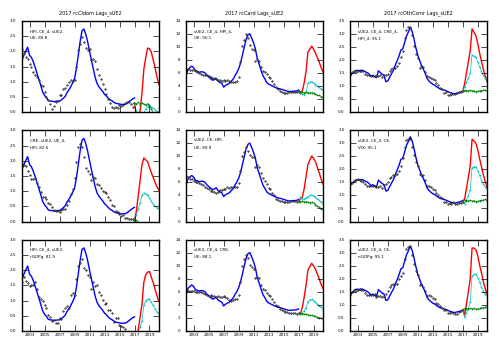

In [141]:
## top3 4-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [142]:
## repeat triple charts cutting off actual and fitted to prior Sept (9/30/2012 for 2013 CCAR)

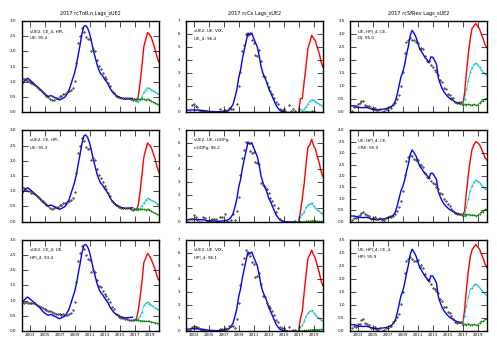

In [143]:
## top3 4-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(ymin=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

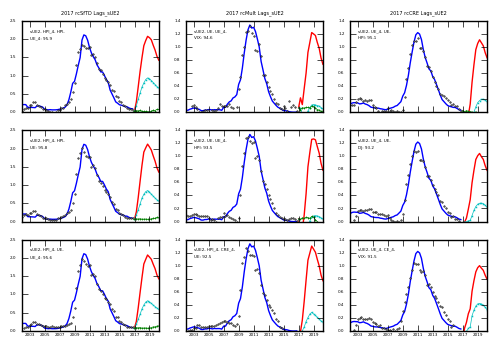

In [144]:
## top3 4-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(ymin=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

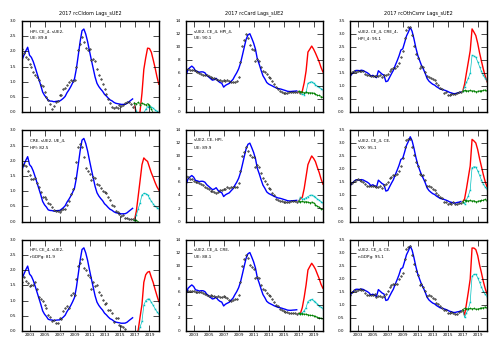

In [145]:
## top3 4-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(ymin=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [146]:
## section to calculate volumes of NCOs from the forecasted NCO rates:

In [147]:
nmlst = ['qncTotLn','qncCx','qncSfRev','qncSfTD','qncMult','qncCRE','qncCIdom','qncCard','qncOthCsmr','qncCREtot'] # numerators in vofi
dmlst = ['eTotLn','eCx','eSfRev','eSfTD','eMult','eCRE','eCIdom','aCard','aOthCsmr','eCREtot'] # denominators in vofi

nmz = dict(zip(rclst, nmlst))
dmz = dict(zip(rclst, dmlst))

#col names to use:
fv = "Fv"  # Fitted model volumes
bv = "Bv"  # Base scenario volumes
av = "Av"  # Adverse scenario volumes
sv = "Sv"  # SevAdv scenario volumes
fm = "Fit"  # these last 4 are model outputs for fitted model & 3 scenarios
bm = "Base"
am = "Adverse"
svm = "SevAdv"  ######### changed on 12/8/15 from sm to svm to avoid statsmodels abbreviation

In [148]:
grporig, styp, irflg

('grpTotUSx00', 'Lags_sUE2', '_NoRates')

In [149]:
## volumes file:
vofi = "df2_3z_"+grporig+".csv"            ## history volumes file for groups to analyze
vo = pd.read_csv(vofi, index_col=0)
vo = vo[vo['Grp']==grp]
vo.rename(columns={"AsOf":"Date"}, inplace=True)
vo['Date'] = pd.to_datetime(vo['Date'])
vo.set_index('Date',drop=True,inplace=True)

dfz1 = []
dfz3 = []

In [150]:
#vv = 2  ## 0,1,2 only:  selects vlst item

#mn = 1 # single models per rc ("full" files)
#mn = 3 # 3 vars per rc ("3v" files)
mn = 4 # 4 vars per rc ("4v" files)

#rkfi = pd.read_csv(grp+'_allyr_' + str(rtyp) +'_'+str(mn)+'v10best_'+cbo[vv]+'.csv', index_col=0)
#rkfi.set_index('ccar',drop=True, inplace=True)

In [151]:
if ccar <= 2015:
  dttr = str(ccar-1) + "-09-30"  # transition date (3rd qtr of year prior to CCAR year)
  dtst = str(ccar-1) + "-12-31"  # start of 9q forecast period
  dten = str(ccar+1) + "-12-31"  # end of 9q forecast period
else:
  dttr = str(ccar-1) + "-12-31"  # transition date (3rd qtr of year prior to CCAR year)
  dtst = str(ccar) + "-03-31"  # start of 9q forecast period
  dten = str(ccar+2) + "-03-31"  # end of 9q forecast period

if ccar >= 2016: 
  vo = vo.ix[:dttr]  # special handling for CCAR years after 2015
else:
  vo = vo.ix[:"2014-12-31"]  # conforms to book exhibits

if mn == 1:
  mtyp = '_full_'
elif mn == 3:
  mtyp = '_3v_'
elif mn == 4:
  mtyp = '_4v_'
else:
  mtyp = 'xxx'  # force error to fix problem
  
hdrw = [0,1] # indicates first 2 rows in forecast file "rtfi" have col headings
  
rtfi = grp + "_" + str(ccar) + mtyp + "9fcst_" + rtyp +"_" + styp +irflg + ".csv" ## file with modeled ccar forecast nco/fail rates
rt = pd.read_csv(rtfi, index_col=0, header=hdrw, parse_dates=True)
  
paramfi = grp + "_" + str(ccar) + mtyp + "9param_" + rtyp +"_"  + styp +irflg + ".csv"  ## param file for same run
param = pd.read_csv(paramfi, index_col=0, header=0)
param.index.name= 'scen'
  
### start prod loops here:
balst= []
dmlst = []

In [152]:
param.head(2)

rc2    v1        r1    v2        r2   v3        r3  v4        r4  \
scen                                                                         
0     rcTotLn  sUE2  0.866796  CE_4  0.909891  HPI  0.916764  UE  0.953608   
1     rcTotLn  sUE2  0.866796    CE  0.904350  HPI  0.911890  UE  0.953481   

           Int        c1        c2        c3        c4        rc  ord  rk  \
scen                                                                        
0     5.631018  0.109980  0.080729 -0.010979 -1.266404  rcTotLn0    0   2   
1     5.624167  0.112326  0.098694 -0.011156 -1.290287  rcTotLn1    0   1   

                               Desc  
scen                                 
0     grpTotUSx00_2017_4v9Lags_sUE2  
1     grpTotUSx00_2017_4v9Lags_sUE2

In [153]:
#for pr in np.arange(2):
for pr in np.arange(len(rt.columns.levels[0])):
  if mn > 1:
    prn = rclst[int(pr/topn)]+str(pr % topn)  # add rank suffix to prodname
  else:
    prn = rclst[int(pr/topn)]    ## just use prodname
  prnm = rclst[int(pr/topn)]     ## prod name (no rank suffix)
  drt = rt[prn]
  df = vo[[nmz[prnm],dmz[prnm]]]
  df.columns = ['nco','bal']
  
  dfr = df.merge(drt, how='outer', left_index=True, right_index=True)
  
  # seed early rows of vol cols with actuals, then calc model vols for forecast periods:
  dfr['Fv'] = dfr['nco']  # added 12/12
  dfr['Bv'] = dfr['nco']
  dfr['Av'] = dfr['nco']
  dfr['Sv'] = dfr['nco']
  
  dfr['bal'] = dfr['bal'].fillna(method='pad')
  dfr[[bm,am,svm]] = dfr[[bm,am,svm]].fillna(-999)
  
  dfr.ix[dttr][bm] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][bm] == -999:
      dfr.ix[x][bv] = dfr.ix[x].nco
      dfr.ix[x][fv] = dfr.ix[x].nco # added 12/12
    else:
      if rtyp == "4q":
        dfr.ix[x][bv] = dfr.ix[x][bm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][bv] +dfr.ix[x-2][bv] +dfr.ix[x-3][bv])
        dfr.ix[x][fv] = dfr.ix[x][fm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][fv] +dfr.ix[x-2][fv] +dfr.ix[x-3][fv])  # added 12/12
      else:
        dfr.ix[x][bv] = dfr.ix[x][bm] * dfr.ix[x].bal/400 
        dfr.ix[x][fv] = dfr.ix[x][fm] * dfr.ix[x].bal/400  # added 12/12
  
  dfr.ix[dttr][am] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][am] == -999:
      dfr.ix[x][av] = dfr.ix[x].nco
    else:
      if rtyp == "4q":
        dfr.ix[x][av] = dfr.ix[x][am] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][av] +dfr.ix[x-2][av] +dfr.ix[x-3][av])
      else:
        dfr.ix[x][av] = dfr.ix[x][am] * dfr.ix[x].bal/400 
  
  dfr.ix[dttr][svm] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][svm] == -999:
      dfr.ix[x][sv] = dfr.ix[x].nco
    else:
      if rtyp == "4q":
        dfr.ix[x][sv] = dfr.ix[x][svm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][sv] +dfr.ix[x-2][sv] +dfr.ix[x-3][sv])
      else:
        dfr.ix[x][sv] = dfr.ix[x][svm] * dfr.ix[x].bal/400 
  
  ## NEW SECTION:
  dfr.replace(to_replace=-999, value=np.nan, inplace=True)  ## replace -999 with nan
  for i in np.arange(len(dfr)):     ## remove forecast Adverse vol if there is no Adverse scenario
    if dfr.iloc[i].name >= pd.to_datetime(dtst):  ## check that this is a forecast period, not history
      if np.isnan(dfr.ix[i]['Adverse']):
        dfr.ix[i]['Av'] = np.nan
  
  dfv = dfr[['Bv','Av','Sv']].ix[dtst:dten].sum()  # 9q forecasts (ignore nco, Fv) 
  
  r9q = pd.rolling_sum(dfr['2006-12-31':dtst]['nco'],window=9, min_periods=9)
  r9q = r9q.dropna()
  r9qm = r9q[r9q==r9q.max()]  # largest 9q losses in history
  
  dfv2 = pd.DataFrame(dfv, columns=[prn])
  dfv2.ix['ActMx'] = r9qm.values[0]
  dfv2.ix['DateMx'] = r9qm.index[0]
  dfv2t = dfv2.T
  dfv2t.reset_index(drop=False, inplace=True)
  
  b9q = pd.rolling_mean(dfr['2006-12-31':dtst]['bal'],window=9, min_periods=9)
  balst = balst + [b9q.ix[r9qm.index[0]]]  ## avg bal for max actual charge-offs
  
  dmlst = dmlst + [dfr['bal'].ix[dtst:dten].mean()]  ## avg bal during CCAR periods
#  voldet = dfr.ix[str(ccar-1)+'-01-01':]
  voldet = dfr.ix[str(ccar-3)+'-01-01':]
  voldet.columns = pd.MultiIndex.from_product([[prn], list(voldet.columns)])
  
  if pr == 0:
    dfvr = dfv2t
    voldet2 = voldet.copy()
  else:
    dfvr = pd.concat([dfvr, dfv2t],ignore_index=True)
#    voldet2 = voldet2.merge(voldet, how='left', left_index=True, right_index=True)
    voldet2 = pd.concat([voldet,voldet2],ignore_index=True,axis=1)

In [154]:
dfvr

index           Bv           Av           Sv        ActMx  \
0     rcTotLn0  8.04061e+07  1.30107e+08  4.27993e+08  3.85018e+08   
1     rcTotLn1  7.45713e+07  1.26706e+08  4.25035e+08  3.85018e+08   
2     rcTotLn2   5.8447e+07  1.57846e+08  4.31344e+08  3.85018e+08   
3        rcCx0      30034.5  5.31228e+06  3.56461e+07  5.21444e+07   
4        rcCx1       311484   8.4351e+06   3.7748e+07  5.21444e+07   
5        rcCx2       495378  9.14819e+06  3.77149e+07  5.21444e+07   
6     rcSfRev0  3.25398e+06  1.61947e+07  3.01539e+07  3.75067e+07   
7     rcSfRev1  3.26035e+06  1.43079e+07  2.96227e+07  3.75067e+07   
8     rcSfRev2  2.71457e+06  1.61006e+07  2.98517e+07  3.75067e+07   
9      rcSfTD0  1.02814e+06  3.58296e+07  8.06072e+07  6.57045e+07   
10     rcSfTD1  3.53179e+06  3.24933e+07  8.15357e+07  6.57045e+07   
11     rcSfTD2  4.48382e+06  3.19411e+07   8.0184e+07  6.57045e+07   
12     rcMult0       626657       695410  8.81751e+06   4.9449e+06   
13     rcMult1       447898      -210908  7.52926e+06   4.9449e+06   
14     rcMult2      -543321  1.53334e+06  8.70047e+06   4.9449e+06   
15      rcCRE0      -767288      -303318  1.89102e+07  2.38932e+07   
16      rcCRE1 -3.62345e+06  4.64663e+06  2.13998e+07  2.38932e+07   
17      rcCRE2 -6.41138e+06  7.81609e+06  2.16722e+07  2.38932e+07   
18    rcCIdom0  4.48528e+06 -3.07515e+06  4.75713e+07  5.03244e+07   
19    rcCIdom1 -9.39391e+06  2.35394e+07  6.01224e+07  5.03244e+07   
20    rcCIdom2 -1.69078e+07  2.09657e+07  4.57669e+07  5.03244e+07   
21     rcCard0  4.69636e+07  6.60169e+07  1.37029e+08  1.09164e+08   
22     rcCard1  4.49347e+07   6.4213e+07  1.39634e+08  1.09164e+08   
23     rcCard2  3.58354e+07  6.68652e+07  1.40337e+08  1.09164e+08   
24  rcOthCsmr0  1.40927e+07  3.26008e+07  4.52801e+07  3.56726e+07   
25  rcOthCsmr1  1.36543e+07  2.97723e+07  4.44741e+07  3.56726e+07   
26  rcOthCsmr2  1.50301e+07  2.95732e+07  4.36693e+07  3.56726e+07   
27   rcCREtot0  2.75601e+06  1.62659e+07  8.99942e+07   7.8101e+07   
28   rcCREtot1  3.74713e+06  2.42871e+07  9.43281e+07   7.8101e+07   
29   rcCREtot2  3.65461e+06  2.31341e+07  9.43487e+07   7.8101e+07   

                 DateMx  
0   2011-03-31 00:00:00  
1   2011-03-31 00:00:00  
2   2011-03-31 00:00:00  
3   2010-12-31 00:00:00  
4   2010-12-31 00:00:00  
5   2010-12-31 00:00:00  
6   2011-03-31 00:00:00  
7   2011-03-31 00:00:00  
8   2011-03-31 00:00:00  
9   2011-03-31 00:00:00  
10  2011-03-31 00:00:00  
11  2011-03-31 00:00:00  
12  2011-06-30 00:00:00  
13  2011-06-30 00:00:00  
14  2011-06-30 00:00:00  
15  2011-12-31 00:00:00  
16  2011-12-31 00:00:00  
17  2011-12-31 00:00:00  
18  2010-12-31 00:00:00  
19  2010-12-31 00:00:00  
20  2010-12-31 00:00:00  
21  2011-06-30 00:00:00  
22  2011-06-30 00:00:00  
23  2011-06-30 00:00:00  
24  2010-06-30 00:00:00  
25  2010-06-30 00:00:00  
26  2010-06-30 00:00:00  
27  2010-12-31 00:00:00  
28  2010-12-31 00:00:00  
29  2010-12-31 00:00:00

In [155]:
voldet.head(2)

rcCREtot2                                                        \
                 nco           bal    Actual       Fit Base Adverse SevAdv   
Date                                                                         
2014-03-31  319373.0  1.603847e+09  0.188441  0.433859  NaN     NaN    NaN   
2014-06-30  402158.0  1.631390e+09  0.140165  0.123655  NaN     NaN    NaN   

                                                    
                  Fv        Bv        Av        Sv  
Date                                                
2014-03-31  319373.0  319373.0  319373.0  319373.0  
2014-06-30  402158.0  402158.0  402158.0  402158.0

In [156]:
if mn > 1:
  dfvr2 = dfvr.copy()
  dfvr2['bal'] = dmlst
  dfvr2['ActBalMx'] = balst
  dfvr2['rk']  = dfvr2.index % mn
  dfvr2['rk'] += 1
  
  dfvr2t = dfvr2.copy()
  dfvr2t['ActMxRt'] = dfvr2t['ActMx']*100/(dfvr2t['ActBalMx']+.000001)
  dfvr2t['ModRt'] = dfvr2t['Sv']*100/(dfvr2t['bal']+.000001)
  dfvr2t = dfvr2t[['index','bal','Bv','Av','Sv','ActMx','ActBalMx','DateMx','ActMxRt','ModRt']] # chgd 12/12 'Fv'
  dfvr2t['Diff'] = dfvr2t['Sv'] - dfvr2t['Bv']
  dfvr2t['Desc'] = grp+"_"+str(ccar) + mtyp + rtyp + styp
  dfvr2t.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg+ "_vol.csv")
  voldet2.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg+ "_voldet.csv")
  dfz3 = dfvr2t.copy()
  
if mn == 1:
  dfvr['bal'] = dmlst
  dfvr['ActBalMx'] = balst
  dfvr[['Bv','Av','Sv','ActMx']] = dfvr[['Bv','Av','Sv','ActMx']].astype(float)
  
  dfvrt = dfvr.copy()
  dfvrt['ActMxRt'] = dfvrt['ActMx']*100/dfvrt['ActBalMx']
  dfvrt['ModRt'] = dfvrt['Sv']*100/dfvrt['bal']
  dfvrt['Diff'] = dfvrt['Sv'] - dfvrt['Bv']
  dfvrt['Desc'] = grp+"_"+str(ccar) + mtyp + rtyp +"_"+ styp
  dfvrt.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_vol.csv")
  voldet.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_voldet.csv")
  dfz1 = dfvrt.copy()

In [157]:
voldet.tail()

rcCREtot2                                                         \
                 nco           bal Actual Fit      Base   Adverse    SevAdv   
Date                                                                          
2019-03-31       NaN  2.019876e+09    NaN NaN  0.077871  0.446910  2.149600   
2019-06-30       NaN  2.019876e+09    NaN NaN  0.060511  0.388330  1.930057   
2019-09-30       NaN  2.019876e+09    NaN NaN  0.056789  0.346208  1.754657   
2019-12-31       NaN  2.019876e+09    NaN NaN  0.056070  0.309745  1.507940   
2020-03-31       NaN  2.019876e+09    NaN NaN  0.052348  0.275217  1.351903   

                                                           
            Fv             Bv            Av            Sv  
Date                                                       
2019-03-31 NaN  707550.545350  3.943086e+06  1.440014e+07  
2019-06-30 NaN -202120.356923  1.282315e+06  4.544916e+06  
2019-09-30 NaN   70548.136303  9.349186e+05  8.699498e+06  
2019-12-31 NaN  556568.395999  9.613625e+04  2.813970e+06  
2020-03-31 NaN  632370.606622  3.245680e+06  1.124838e+07

In [158]:
grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_vol.csv"

'grpTotUSx00_2017_4v_4q_Lags_sUE2_NoRates_vol.csv'

In [159]:
grp = grporig  # reset to original grp designation
grp, styp, irflg, ccar

('grpTotUSx00', 'Lags_sUE2', '_NoRates', 2017)